# Import libs and data

In [1]:
import matplotlib.pyplot as plt
from collections import Counter
import re
import pandas as pd
from tinydb import TinyDB, Query
from config import *

In [2]:
db = TinyDB(DB_FILE)
processed_table = db.table(TABLE_PROCESSED)

In [3]:
data = processed_table.all() 
df = pd.DataFrame(data)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              727 non-null    object 
 1   min_salary         77 non-null     float64
 2   max_salary         66 non-null     float64
 3   salary_currency    95 non-null     object 
 4   minimum_education  729 non-null    object 
 5   languages          729 non-null    object 
 6   experience         479 non-null    float64
 7   responsibilities   729 non-null    object 
 8   hard_skills        729 non-null    object 
 9   soft_skills        729 non-null    object 
 10  certifications     729 non-null    object 
 11  benefits           729 non-null    object 
 12  city               371 non-null    object 
 13  country            407 non-null    object 
 14  company_name       727 non-null    object 
 15  company_size       427 non-null    object 
 16  employment_type    726 non

,title,min_salary,max_salary,salary_currency,minimum_education,languages,experience,responsibilities,hard_skills,soft_skills,...,company_size,employment_type,work_schedule,contract_type,remote_work,job_categories,date,source,occurrences,original_url
0,dotnet developer,NaN,NaN,None,none,[ro],2.0,[],[dotnet],[],...,None,full-time,None,None,on-site,[programming],30/05/2025,robota.md,"[04/06/2025, 30/05/2025, 05/06/2025, 02/06/202...",https://www.rabota.md/ro/joburi/middle-net-dev...
1,golang developer,NaN,NaN,None,none,[en],3.0,"[traffic processing, ensure stability, design ...","[golang, http, https, multithreading, sql, gra...","[teamwork, problem solving]",...,None,full-time,flexible,permanent,hybrid,[programming],30/05/2025,robota.md,"[30/05/2025, 02/06/2025, 01/06/2025, 31/05/2025]",https://www.rabota.md/ro/locuri-de-munca/middl...
2,1c programmer,NaN,NaN,None,bachelor,"[ro, ru]",1.0,[],[1c],[],...,None,full-time,standard,permanent,on-site,[programming],30/05/2025,robota.md,"[04/06/2025, 30/05/2025, 01/06/2025, 05/06/202...",https://www.rabota.md/ro/locuri-de-munca/progr...
3,ios developer,NaN,NaN,None,unspecified,"[ro, ru]",1.0,"[develop, maintain, optimize, collaborate, debug]","[swift, swiftui, cocoapods, git, oop, mvc, mvv...",[],...,None,full-time,standard,permanent,on-site,[programming],30/05/2025,robota.md,"[04/06/2025, 30/05/2025, 01/06/2025, 05/06/202...",https://www.rabota.md/ro/locuri-de-munca/ios-d...
4,devops engineer,NaN,NaN,None,none,[en],3.0,"[analyze, design, develop, build, test, deploy...","[aws, amazon cloudwatch, azure, cicd, docker, ...",[],...,None,full-time,standard,permanent,on-site,[programming],30/05/2025,robota.md,"[04/06/2025, 30/05/2025, 01/06/2025, 05/06/202...",https://www.rabota.md/ro/locuri-de-munca/devop...


# Disable a datasource

In [ ]:
# Specify the source to drop
# source_to_drop = "linkedin.com"
# source_to_drop = "robota.md"

# Drop rows where the source matches
# df = df[df["source"] != source_to_drop].reset_index(drop=True)


# Query for tech skill occurences

In [5]:
import pandas as pd

keyword = 'rust'  # your search keyword

filtered_df = df[df['hard_skills'].apply(lambda skills: keyword.lower() in [s.lower() for s in skills] if isinstance(skills, list) else False)]


print(f"Number of entities found with hard_skill '{keyword}': {len(filtered_df)}\n")

from tabulate import tabulate

print(tabulate(filtered_df[['title', 'hard_skills']], headers='keys', tablefmt='grid'))



Number of entities found with hard_skill 'rust': 8

+-----+----------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|     | title                | hard_skills                                                                                                                                                                                                                  |
+=====+======================+==============================================================================================================================================================================================================================+
| 348 | blockchain developer | ['rust', 'cosmwasm', 'golang', 'typescript', 'blockchain', 'smart contracts', 'evm']                                                                       

# Plot daily open vacancies

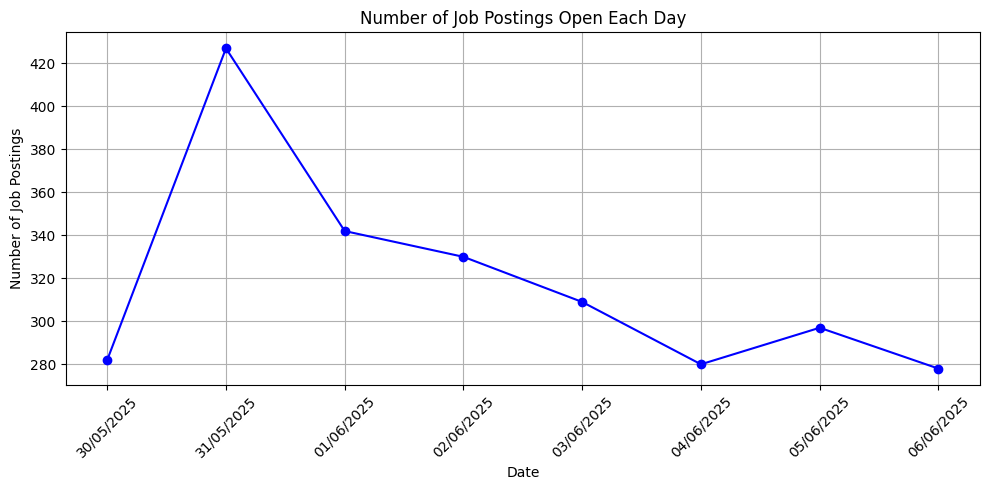

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter
from utils import parse_date

# Flatten occurrence dates
all_dates = []
for occ_list in df['occurrences'].dropna():
    if isinstance(occ_list, list):
        all_dates.extend(occ_list)
    elif isinstance(occ_list, str):
        all_dates.append(occ_list)

# Parse dates
date_objects = [parse_date(d) for d in all_dates]

# Count occurrences per date
date_counts = Counter(date_objects)

# Sort dates
sorted_dates = sorted(date_counts.items())
dates, counts = zip(*sorted_dates)

plt.figure(figsize=(10, 5))
plt.plot(dates, counts, marker='o', linestyle='-', color='b')

plt.title("Number of Job Postings Open Each Day")
plt.xlabel("Date")
plt.ylabel("Number of Job Postings")
plt.grid(True)

# Set major locator and formatter for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())  # Tick every day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))  # Format as DD/MM/YYYY

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



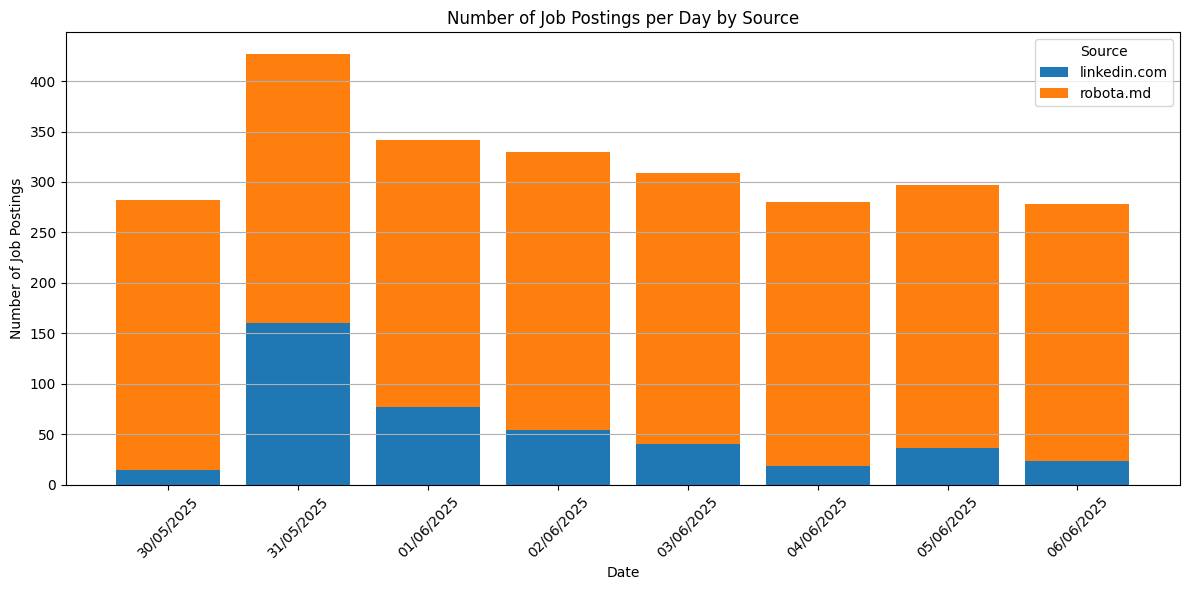

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
from utils import parse_date
import pandas as pd

# Prepare nested dictionary: {date: {source: count}}
date_source_counts = defaultdict(lambda: defaultdict(int))

for idx, row in df.dropna(subset=['occurrences', 'source']).iterrows():
    source = row['source']
    occ_list = row['occurrences']
    
    if not isinstance(occ_list, list):
        occ_list = [occ_list]
    
    for d in occ_list:
        date_obj = parse_date(d)
        date_source_counts[date_obj][source] += 1

# Get sorted unique dates
all_dates = sorted(date_source_counts.keys())

# Get list of all sources
all_sources = sorted({source for counts in date_source_counts.values() for source in counts})

# Prepare data for stacked bar chart
counts_per_source = {source: [] for source in all_sources}

for date in all_dates:
    counts_for_date = date_source_counts[date]
    for source in all_sources:
        counts_per_source[source].append(counts_for_date.get(source, 0))

# Plot stacked bars
plt.figure(figsize=(12, 6))
bottom = [0] * len(all_dates)

for source in all_sources:
    plt.bar(all_dates, counts_per_source[source], bottom=bottom, label=source)
    bottom = [sum(x) for x in zip(bottom, counts_per_source[source])]

plt.title("Number of Job Postings per Day by Source")
plt.xlabel("Date")
plt.ylabel("Number of Job Postings")
plt.grid(axis='y')

# Format x-axis dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

plt.xticks(rotation=45)
plt.legend(title="Source")
plt.tight_layout()
plt.show()


## Jobs alive

X-axis spans 8 days from 2025-05-30 00:00:00 to 2025-06-06 00:00:00
DEBUG: Examining first 10 jobs:
Job 1:
  Occurrences: ['30/05/2025']
  Start date (min occurrence): 2025-05-30 00:00:00
  End date (max occurrence): 2025-05-30 00:00:00
  Duration: 0 days
  Same day? True

Job 2:
  Occurrences: ['30/05/2025']
  Start date (min occurrence): 2025-05-30 00:00:00
  End date (max occurrence): 2025-05-30 00:00:00
  Duration: 0 days
  Same day? True

Job 3:
  Occurrences: ['30/05/2025']
  Start date (min occurrence): 2025-05-30 00:00:00
  End date (max occurrence): 2025-05-30 00:00:00
  Duration: 0 days
  Same day? True

Job 4:
  Occurrences: ['30/05/2025']
  Start date (min occurrence): 2025-05-30 00:00:00
  End date (max occurrence): 2025-05-30 00:00:00
  Duration: 0 days
  Same day? True

Job 5:
  Occurrences: ['30/05/2025']
  Start date (min occurrence): 2025-05-30 00:00:00
  End date (max occurrence): 2025-05-30 00:00:00
  Duration: 0 days
  Same day? True

Job 6:
  Occurrences: ['30/05/

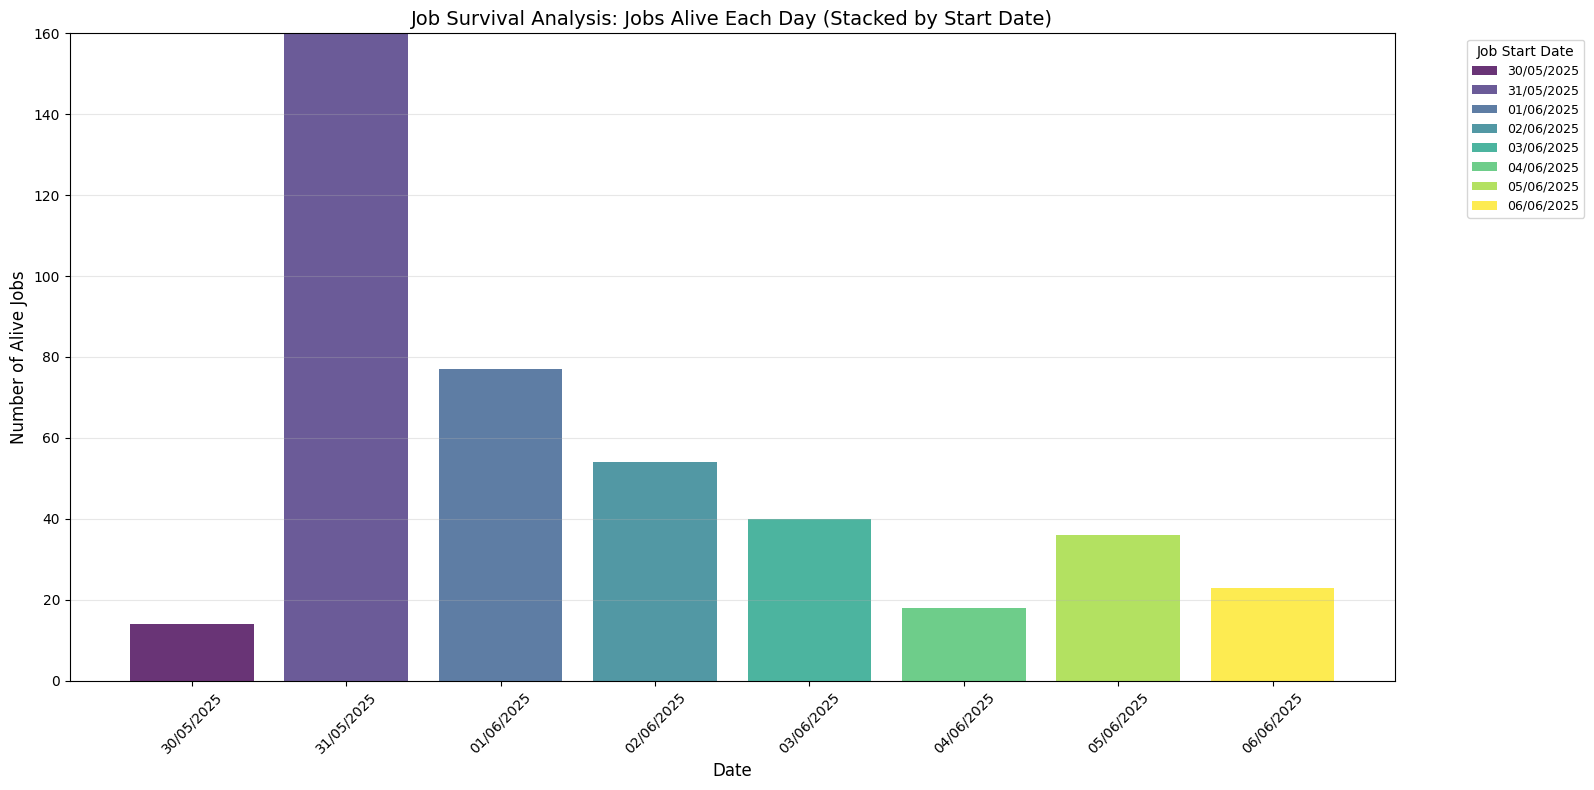


Summary:
Peak alive jobs: 160 on 31/05/2025
Average jobs alive per day: 52.8

Evolution of jobs from first 3 start dates:
  30/05/2025: Peak 14 jobs, lasted 1 days
  31/05/2025: Peak 160 jobs, lasted 1 days
  01/06/2025: Peak 77 jobs, lasted 1 days


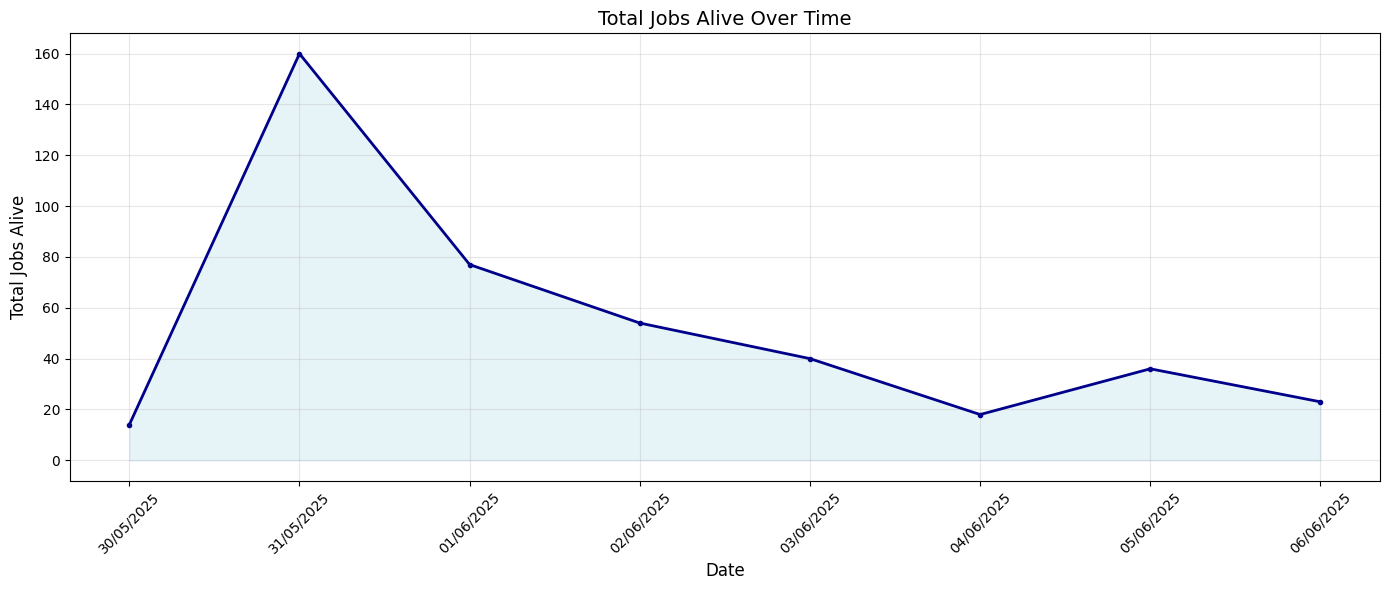

In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from collections import defaultdict
from utils import parse_date

# Get all unique dates for x-axis (from both date column and occurrences)
all_dates = set()

# Add dates from date column
for d in df['date'].dropna():
    all_dates.add(parse_date(d))

# Add dates from occurrences
for idx, row in df.iterrows():
    occ_value = row['occurrences']
    try:
        # Skip if None or empty
        if occ_value is None:
            continue
        
        # Handle different data types
        if isinstance(occ_value, (list, np.ndarray)):
            occ_list = occ_value
        else:
            # Single value or string
            occ_list = [occ_value]
        
        for occ_date in occ_list:
            try:
                if occ_date is not None and str(occ_date).strip() != '' and str(occ_date).lower() != 'nan':
                    all_dates.add(parse_date(occ_date))
            except:
                continue  # Skip invalid dates
    except:
        continue  # Skip problematic rows

# Sort all dates for x-axis
x_axis_dates = sorted(all_dates)
print(f"X-axis spans {len(x_axis_dates)} days from {x_axis_dates[0]} to {x_axis_dates[-1]}")

# For each x-axis date, count how many jobs from each start date are still alive
survival_data = {}  # {start_date: [count_day1, count_day2, ...]}

# Process each job
job_count = 0
multi_day_jobs = 0

print("DEBUG: Examining first 10 jobs:")
debug_count = 0

for idx, row in df.dropna(subset=['occurrences']).iterrows():
    occ_list = row['occurrences']
    if not isinstance(occ_list, list):
        occ_list = [occ_list]
    
    # Parse all occurrence dates
    parsed_occurrences = []
    for occ_date in occ_list:
        try:
            if occ_date is not None and str(occ_date).strip() != '' and str(occ_date).lower() != 'nan':
                parsed_occurrences.append(parse_date(occ_date))
        except:
            continue
    
    if not parsed_occurrences:
        continue
        
    # Find start and end dates from occurrences
    start_date = min(parsed_occurrences)
    end_date = max(parsed_occurrences)
    
    job_count += 1
    
    # Initialize survival data for this start date if needed
    if start_date not in survival_data:
        survival_data[start_date] = [0] * len(x_axis_dates)
    
    # Debug first 10 jobs
    if debug_count < 10:
        print(f"Job {debug_count + 1}:")
        print(f"  Occurrences: {occ_list}")
        print(f"  Start date (min occurrence): {start_date}")
        print(f"  End date (max occurrence): {end_date}") 
        print(f"  Duration: {(end_date - start_date).days} days")
        print(f"  Same day? {start_date.date() == end_date.date()}")
        print()
        debug_count += 1
    
    # Check if job lives more than one day
    if (end_date - start_date).days > 0:
        multi_day_jobs += 1
        if multi_day_jobs <= 5:  # Show first 5 examples
            print(f"Multi-day job example: starts {start_date.strftime('%Y-%m-%d')}, ends {end_date.strftime('%Y-%m-%d')}, duration: {(end_date - start_date).days} days")
    
    # OPTION 1: Mark job as alive from start to end date (continuous survival)
    for day_idx, current_day in enumerate(x_axis_dates):
        if start_date <= current_day <= end_date:
            survival_data[start_date][day_idx] += 1
    
    # OPTION 2: Only mark job as alive on days it was actually observed
    # Uncomment these lines and comment out the above loop to use this approach:
    # for occurrence_date in parsed_occurrences:
    #     if occurrence_date in x_axis_dates:
    #         day_idx = x_axis_dates.index(occurrence_date)
    #         survival_data[start_date][day_idx] += 1

print(f"Total jobs processed: {job_count}")
print(f"Jobs lasting more than 1 day: {multi_day_jobs}")
print(f"Percentage of multi-day jobs: {multi_day_jobs/job_count*100:.1f}%")

# Sort start dates (oldest first for bottom stacking)
start_dates_sorted = sorted(survival_data.keys())

print(f"Found {len(start_dates_sorted)} different start dates")
print(f"Total jobs analyzed: {job_count}")

# DEBUG: Show the survival matrix
print(f"\nSurvival Matrix (rows=start_dates, cols=timeline_days):")
print("Start Date    ->", " | ".join([d.strftime('%m/%d') for d in x_axis_dates]))
for start_date in start_dates_sorted:
    counts = survival_data[start_date]
    print(f"{start_date.strftime('%m/%d')} -> {counts}")

# Check if we have any cross-day survival
total_per_day = [sum(survival_data[start_date][day_idx] for start_date in start_dates_sorted) 
                 for day_idx in range(len(x_axis_dates))]
print(f"\nTotal jobs per day: {total_per_day}")

# Check how many start dates contribute to each day
for day_idx, day in enumerate(x_axis_dates):
    contributing_starts = [start_date for start_date in start_dates_sorted 
                          if survival_data[start_date][day_idx] > 0]
    if len(contributing_starts) > 1:
        print(f"Day {day.strftime('%m/%d')} has jobs from {len(contributing_starts)} different start dates: {[d.strftime('%m/%d') for d in contributing_starts]}")

# Create the stacked bar chart
plt.figure(figsize=(16, 8))

# Use a more professional color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(start_dates_sorted)))

x = np.arange(len(x_axis_dates))
bottom = np.zeros(len(x_axis_dates))

# Stack from oldest (bottom) to newest (top)
for i, start_date in enumerate(start_dates_sorted):
    counts = survival_data[start_date]
    
    # Only plot if there are any jobs from this start date
    if max(counts) > 0:
        plt.bar(x, counts, bottom=bottom, color=colors[i], width=0.8,
                label=start_date.strftime('%d/%m/%Y'), alpha=0.8)
        bottom += counts

plt.title("Job Survival Analysis: Jobs Alive Each Day (Stacked by Start Date)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Alive Jobs", fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Format x-axis
ax = plt.gca()
step = max(1, len(x)//15)  # Show ~15 labels
ax.set_xticks(x[::step])
ax.set_xticklabels([d.strftime('%d/%m/%Y') for d in x_axis_dates[::step]], rotation=45)

# Legend (limit if too many start dates)
if len(start_dates_sorted) <= 15:
    plt.legend(title="Job Start Date", bbox_to_anchor=(1.05, 1), loc='upper left',
              fontsize=9, title_fontsize=10)
else:
    # Just show text about number of cohorts if too many
    plt.text(1.02, 0.5, f"{len(start_dates_sorted)} different\nstart dates\n(oldest at bottom)", 
             transform=ax.transAxes, fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.show()

# Print some statistics
peak_day_idx = np.argmax(total_per_day)
peak_count = total_per_day[peak_day_idx]
peak_date = x_axis_dates[peak_day_idx]

print(f"\nSummary:")
print(f"Peak alive jobs: {peak_count} on {peak_date.strftime('%d/%m/%Y')}")
print(f"Average jobs alive per day: {np.mean(total_per_day):.1f}")

# Show how jobs from first few start dates evolve
print(f"\nEvolution of jobs from first 3 start dates:")
for i, start_date in enumerate(start_dates_sorted[:3]):
    counts = survival_data[start_date]
    max_count = max(counts)
    days_alive = len([c for c in counts if c > 0])
    print(f"  {start_date.strftime('%d/%m/%Y')}: Peak {max_count} jobs, lasted {days_alive} days")

# Simple line plot showing total alive jobs
plt.figure(figsize=(14, 6))
plt.plot(x, total_per_day, marker='o', linewidth=2, markersize=3, color='darkblue')
plt.fill_between(x, total_per_day, alpha=0.3, color='lightblue')
plt.title("Total Jobs Alive Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Jobs Alive", fontsize=12)
plt.grid(True, alpha=0.3)

ax = plt.gca()
ax.set_xticks(x[::step])
ax.set_xticklabels([d.strftime('%d/%m/%Y') for d in x_axis_dates[::step]], rotation=45)

plt.tight_layout()
plt.show()

# Most common keywords in job titles (raw data)

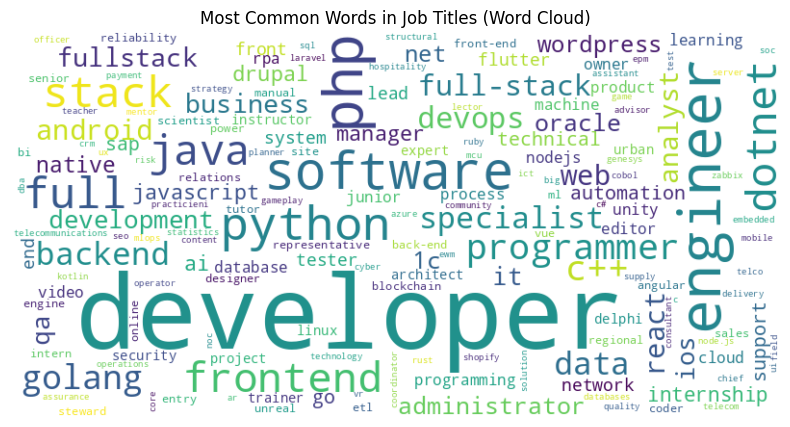

Full list of word frequencies:

developer            528
engineer             68
php                  62
software             56
python               45
full                 37
stack                37
dotnet               35
java                 35
frontend             34
programmer           24
c++                  24
golang               21
data                 19
backend              19
specialist           18
devops               17
full-stack           16
react                15
android              15
web                  15
analyst              14
fullstack            13
business             13
ios                  12
qa                   12
development          12
it                   12
1c                   11
administrator        11
oracle               11
net                  10
wordpress            10
native               9
ai                   8
javascript           8
manager              8
drupal               8
internship           7
automation           6
technical     

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Assuming df is already defined and loaded with your job title data
# If 'df' is not defined, you'll need to load your data into a pandas DataFrame first.
# Example: df = pd.read_csv('your_job_data.csv') or df = pd.DataFrame({'title': ['job title 1', 'job title 2']})

# Flatten all words into a single list
all_words = [word for title in df['title'].dropna() for word in title.split()]

# Count occurrences
word_counts = Counter(all_words)

# Generate the word cloud
# You can customize parameters like width, height, background_color, collocations, etc.
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(word_counts)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Do not show axes
plt.title('Most Common Words in Job Titles (Word Cloud)')
plt.show()

# Print full list sorted by frequency (as originally requested)
print("Full list of word frequencies:\n")
for word, count in word_counts.most_common():
    print(f"{word:20} {count}")

In [10]:
# Raw, non processed titles
# Get the value counts of the 'title' column
title_counts = df['title'].value_counts()

# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)

# Display all job title occurrences
print("All Job Title Occurrences:")
print(title_counts)

All Job Title Occurrences:
title
php developer                        56
software developer                   40
python developer                     39
java developer                       35
full stack developer                 34
frontend developer                   31
dotnet developer                     27
c++ developer                        24
golang developer                     19
backend developer                    17
full-stack developer                 16
android developer                    15
web developer                        13
devops engineer                      13
ios developer                        12
1c programmer                        11
software engineer                     9
react native developer                9
wordpress developer                   8
drupal developer                      8
net developer                         7
data engineer                         7
javascript developer                  7
fullstack developer                   7
go deve

# Chrrypick job positionswith regex

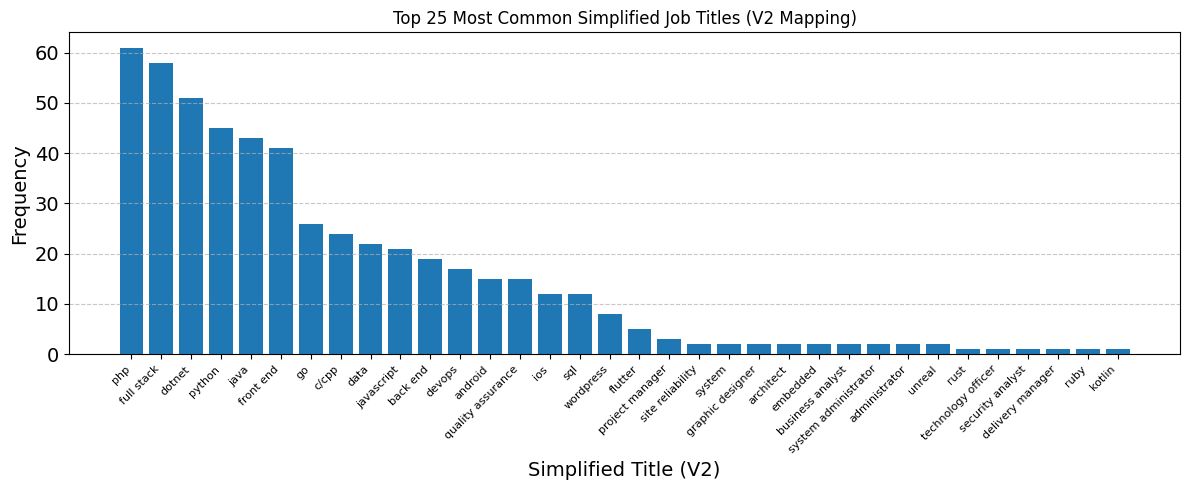


All Simplified Job Title Occurrences (Programming Languages Top, iOS/Android Higher, Full Stack Lower):
simplified_title_reordered_v2
php                     61
full stack              58
dotnet                  51
python                  45
java                    43
front end               41
go                      26
c/cpp                   24
data                    22
javascript              21
back end                19
devops                  17
android                 15
quality assurance       15
ios                     12
sql                     12
wordpress                8
flutter                  5
project manager          3
site reliability         2
system                   2
graphic designer         2
architect                2
embedded                 2
business analyst         2
system administrator     2
administrator            2
unreal                   2
rust                     1
technology officer       1
security analyst         1
delivery manager         1
r

In [11]:
# Cherry Pick with regex best words

# 1. Define dictionary with keyword / simplified titles you experienceect (priority matters implicitly by order)
JOB_KEYWORD_MAPPING_REORDERED_V2 = {
    # Programming Languages (Prioritized and ordered by perceived commonality/specificity)
    'python': r'python',
    'kotlin': r'kotlin',
    'java': r'java|full stack java|spring',
    'dotnet': r'\.net|dot[-\s]?net|net|asp\.net|aspdotdotnet|dotnetwork|dotdotnet|csharp/dotdotnet|aspdotdotnet dotdotnet|dotdotnet core|dotdotnet developers|c#|c[-\s]?sharp|csharp|asp\.net|dotdotnet',
    'javascript': r'node\.?js|nodejavascript|reactjs|react|react native|angularjs|angular|vue.javascript|vue.js', # Combining related JS frameworks
    'php': r'php symfony|php',
    'go': r'golang|go',
    'rust': r'rust',
    'swift': r'swift',
    'haskel': r'haskel|lisp',
    'ruby': r'ruby|rails', # Assuming Rails is specific to Ruby
    'c/cpp': r'c\+\+|c/cpp',
    'sql': r'sql|oracle|microsoft dynamics', # Databases related to programming

    # Mobile Development
    'ios': r'ios',
    'android': r'android',
    'flutter': r'flutter/dart|flutter',

    # Front-End and Back-End (Full Stack below)
    'front end': r'front[-\s]?end',
    'back end': r'back[-\s]?end|dotdotnet back end|back end nodejavascript',
    'full stack': r'full[-\s]?stack|full stack web|full stack web development|full stack development|arhitect full stack|dezvoltator full stack|full stack php|full stack dotdotnet',

    # Quality Assurance
    'quality assurance': r'qa|quality assurance|quality assurance analyst|automation quality assurance|quality assurance tester|tester',

    # Data Related
    'data': r'data analyst|data|data analyst data scientist|etl data tester|data steward',

    # DevOps and System Administration
    'devops': r'devops|azure devops|system devops',
    'system administrator': r'system administrator|linux dotnetwork administrator|system administrator helpdesk|web administrator',
    'linux administrator': r'linux',
    'monitoring operator': r'monitoring operator',
    'infrastructure support': r'infrastructure support',
    'system': r'system|linux dotnetwork system administrator',

    # Management/Leadership
    'project manager': r'project manager|software project manager',
    'product manager': r'product manager',
    'technology officer': r'technology officer',
    'delivery manager': r'delivery manager',
    'team lead': r'team lead', # Assuming this was a desired category (not in original, but often relevant)
    'architect': r'architect',

    # Analysis and Design
    'business analyst': r'business analyst|business analyst project coordinator',
    'ui ux designer': r'ui[/]?ux',
    'erp analyst': r'erp analyst',
    'market research analyst': r'market research analyst',
    'graphic designer': r'grafic designer|graphic designer|designer',
    'artist': r'artist',

    # Other Technical Roles
    'embedded': r'embedded|mcu',
    'unreal': r'unreal engine|unreal game |unrealdeveloper',
    'security analyst': r'security analyst',
    'cybersecurity': r'cybersecurity',
    'site reliability': r'site reliability',
    'mobile application': r'mobile application', # Keeping it here as it's a type of application
    'web': r'веб|веб-программист|web designer', # Broader web category
    'r&d': r'r&d',
    'wordpress': r'wordpress', # Could be web development, but often distinct
    'administrator': r'administrator', # Very general
        
    'UNKNOWN': 'other', # Default category if no keyword is found
}

def categorize_title_reordered_v2(title):
    """
    Passes through the job title and categorizes it based on the reordered
    predefined keywords with programming languages on top, full stack below
    front/back end, and iOS/Android higher.
    """
    if isinstance(title, str):
        processed_title = title.lower().strip()
        processed_title = re.sub(r'\([^)]*\)', '', processed_title).strip() # Remove parentheses content

        for category, pattern in JOB_KEYWORD_MAPPING_REORDERED_V2.items():
            if re.search(pattern, processed_title):
                return category
        return 'other'
    return 'other'

# Recalculate categorization
df['simplified_title_reordered_v2'] = df['title'].apply(categorize_title_reordered_v2)


# Get the value counts of the prioritized simplified titles (version 2)
simplified_title_counts_reordered_v2 = df['simplified_title_reordered_v2'].value_counts()

# remove other keyword
del simplified_title_counts_reordered_v2["other"]

plt.figure(figsize=(12, 5))
plt.bar(simplified_title_counts_reordered_v2.index, simplified_title_counts_reordered_v2.values)
plt.title('Top 25 Most Common Simplified Job Titles (V2 Mapping)')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Simplified Title (V2)', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Display all prioritized simplified job title occurrences (version 2)
print("\nAll Simplified Job Title Occurrences (Programming Languages Top, iOS/Android Higher, Full Stack Lower):")
print(simplified_title_counts_reordered_v2)


In [12]:
import pandas as pd
from collections import defaultdict, Counter

def get_ngrams(text, n):
    """
    Generates a set of n-grams from the given text.

    Args:
        text (str): The input text.
        n (int): The length of the n-grams.

    Returns:
        set: A set of n-grams.  Returns an empty set if text is shorter than n.
    """
    if len(text) < n:
        return set()
    return set(text[i:i+n] for i in range(len(text) - n + 1))

def ngram_similarity(term1, term2, n=3):
    """
    Calculates the n-gram similarity between two terms.

    Args:
        term1 (str): The first term.
        term2 (str): The second term.
        n (int, optional): The length of the n-grams. Defaults to 3.

    Returns:
        float: The n-gram similarity (between 0 and 1). Returns 0 if both terms are empty.
    """
    ngrams1 = get_ngrams(term1, n)
    ngrams2 = get_ngrams(term2, n)
    intersection = ngrams1.intersection(ngrams2)
    union = ngrams1.union(ngrams2)
    return len(intersection) / len(union) if union else 0.0  # Handle empty case

def cluster_terms_by_ngram_similarity(df, column_name, similarity_threshold=0.15, n=3, b_print=False):
    """
    Clusters terms in a DataFrame column based on n-gram similarity, and prints the clusters.

    Args:
        df (pd.DataFrame): The DataFrame containing the terms.
        column_name (str): The name of the column containing the terms (lists of strings).
        similarity_threshold (float, optional): The similarity threshold for clustering. Defaults to 0.15.
        n (int, optional): The length of the n-grams to use for comparison. Defaults to 3.
    """
    # 1. Extract and flatten the list of terms, handling NaNs robustly
    all_things = [tech for tech_list in df[column_name].dropna() for tech in (tech_list if isinstance(tech_list, list) else [tech_list])]

    # 2. Count occurrences of each term
    counts = Counter(all_things)

    # 3. Initialize data structures for clustering
    clusters = defaultdict(list)
    terms = list(counts.keys())
    assigned = set()

    # 4. Perform the clustering
    for i, term1 in enumerate(terms):
        if i not in assigned:
            clusters[term1].append(term1)
            assigned.add(i)
            for j in range(i + 1, len(terms)):
                if j not in assigned:
                    similarity = ngram_similarity(term1, terms[j], n=n)
                    if similarity >= similarity_threshold:
                        clusters[term1].append(terms[j])
                        assigned.add(j)

    if b_print == True:
        # 5. Print the results
        print(f"Potential Clusters (N-gram, Threshold={similarity_threshold}, N={n}):")
        if not clusters:
            print("No clusters found.")  # Handle the case where no clusters are formed.
            return
    
        for key, value in clusters.items():
            if len(value) > 1:
                print(f"  {key}: {', '.join(value)}")
            
    return clusters #returning the clusters, in case the user wants to use them

In [13]:
def analyze_and_visualize_consolidated_terms(df, column_name, similarity_threshold=0.15, n=2, top_n=20, 
                                     figsize=(10, 5), rotation=45, show_details=True):
    """
    Analyzes, consolidates, and visualizes terms from a specified DataFrame column,
    grouping similar terms based on n-gram similarity.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the terms.
        column_name (str): The name of the column containing the terms (lists of strings).
        similarity_threshold (float, optional): The similarity threshold for clustering. Defaults to 0.15.
        n (int, optional): The length of the n-grams to use for comparison. Defaults to 2.
        top_n (int, optional): Number of top terms to visualize. Defaults to 20.
        figsize (tuple, optional): Figure size for the plot. Defaults to (10, 5).
        rotation (int, optional): Rotation angle for x-axis labels. Defaults to 45.
        show_details (bool, optional): Whether to print consolidation details. Defaults to True.
        
    Returns:
        tuple: (consolidated_counts, clusters) - Counter object with consolidated counts and clusters dictionary
    """
    import matplotlib.pyplot as plt
    from collections import Counter
    
    # Extract and flatten all terms from the specified column
    all_terms = [term for term_list in df[column_name].dropna() for term in 
                (term_list if isinstance(term_list, list) else [term_list])]
    
    # Count occurrences
    original_counts = Counter(all_terms)
    
    # Generate clusters
    clusters = cluster_terms_by_ngram_similarity(df, column_name, 
                                               similarity_threshold=similarity_threshold, n=n)
    
    # Create a mapping from each term to its cluster representative (the cluster key)
    term_to_cluster = {}
    for cluster_key, terms in clusters.items():
        for term in terms:
            term_to_cluster[term] = cluster_key
    
    # Consolidate counts based on clusters
    consolidated_counts = Counter()
    for term, count in original_counts.items():
        # If the term is in a cluster, add its count to the cluster key
        if term in term_to_cluster:
            consolidated_counts[term_to_cluster[term]] += count
        else:
            # If not in any cluster, keep it as is
            consolidated_counts[term] += count
    
    # Plot top N most common consolidated terms
    top_terms = dict(consolidated_counts.most_common(top_n))
    plt.figure(figsize=figsize)
    plt.bar(top_terms.keys(), top_terms.values())
    plt.title(f'Top {top_n} Most Common {column_name.capitalize()}')
    plt.xticks(rotation=rotation, ha='right')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # Print full list sorted by frequency
    print(f"Full list of consolidated {column_name} term frequencies:\n")
    for term, count in consolidated_counts.most_common():
        print(f"{term:20} {count}")
    
    # Optionally, print which terms were consolidated
    if show_details:
        print("\nConsolidation details:")
        for cluster_key, terms in clusters.items():
            if len(terms) > 1:
                total_count = sum(original_counts[term] for term in terms)
                print(f"{cluster_key} ({total_count}): {', '.join(terms)}")
    
    return consolidated_counts, clusters

In [14]:
GENERIC_JOB_KEYWORD_MAPPING = {
    # Programming Roles
    'backend': r'\b(back[-\s]?end|node\.?js|golang|php|ruby|rails|python|java|dotnet|net|\.net|asp\.net|c#|c[-\s]?sharp|c\+\+|c/cpp)\b',
    'frontend': r'\b(front[-\s]?end|react(\.js)?|angular(\.js)?|vue(\.js)?|javascript|html|css)\b',
    'full stack': r'\bfull[-\s]?stack\b',
    
    # Mobile Development
    'mobile developer': r'\b(android|ios|flutter|react native|mobile application|kotlin)\b',

    # Data/Analytics
    'data': r'\b(data|data analyst|etl|data scientist|data steward|sql|oracle)\b',

    # Quality Assurance / Testing
    # 'qa tester': r'\b(qa|quality assurance|tester|automation)\b',

    # DevOps and Infrastructure
    'devops': r'\b(devops|azure devops|site reliability|infrastructure support)\b',
    # 'sysadmin': r'\b(system administrator|linux|web administrator|monitoring operator|administrator)\b',

    # UI/UX & Design
    # 'ui/ux designer': r'\b(ui[/]?[ ]?ux|designer|graphic designer|grafic designer)\b',

    # Management & Lead Roles
    # 'manager': r'\b(project manager|product manager|delivery manager|team lead|technology officer|architect)\b',

    # Analyst & Business Roles
    # 'analyst': r'\b(business analyst|market research analyst|erp analyst)\b',

    # Security
    # 'security': r'\b(security analyst|cybersecurity)\b',

    # Game
    'gamedev': r'\b(unity|unreal engine|unreal|godot)\b',

    # Web Development (broad)
    # 'web': r'\b(web|wordpress|веб|веб-программист)\b',

    # Research & Development
    # 'r&d': r'\br&d\b',

    # Fallback
    # 'other': r'.*',
}


In [15]:
def extract_generic_title(title, mapping):
    if not isinstance(title, str):
        return None
    for generic_title, pattern in mapping.items():
        if re.search(pattern, title, flags=re.IGNORECASE):
            return generic_title
    return None

df['generic_title'] = df['title'].apply(lambda x: extract_generic_title(x, GENERIC_JOB_KEYWORD_MAPPING))

In [16]:
import pandas as pd
from collections import Counter

filtered_df = df[df['generic_title'].notna()]

# Store counts per job title
tech_data = {}
soft_data = {}

for job in filtered_df['generic_title'].unique():
    subset = filtered_df[filtered_df['generic_title'] == job]
    
    # Tech skills counts
    tech_skills = [skill for skills_list in subset['hard_skills'].dropna() for skill in skills_list]
    tech_counts = Counter(tech_skills)
    tech_data[job] = tech_counts
    
    # Soft skills counts
    soft_skills = [skill for skills_list in subset['soft_skills'].dropna() for skill in skills_list]
    soft_counts = Counter(soft_skills)
    soft_data[job] = soft_counts

def build_ranked_df(skill_data, top_n=10):
    jobs = list(skill_data.keys())
    ranked_dict = {job: [] for job in jobs}
    
    # Build lists of top skills with counts as strings per job
    for job in jobs:
        top_skills = skill_data[job].most_common(top_n)
        ranked_dict[job] = [f"{skill} ({count})" for skill, count in top_skills]
        
        # Pad with empty strings if less than top_n skills
        if len(ranked_dict[job]) < top_n:
            ranked_dict[job].extend([''] * (top_n - len(ranked_dict[job])))
    
    # Create DataFrame with ranks as index
    ranked_df = pd.DataFrame(ranked_dict, index=[f"Rank {i+1}" for i in range(top_n)])
    return ranked_df

# Create ranked DataFrames
tech_ranked_df = build_ranked_df(tech_data, top_n=25)
soft_ranked_df = build_ranked_df(soft_data, top_n=25)

# Hard and Soft Skills by job position

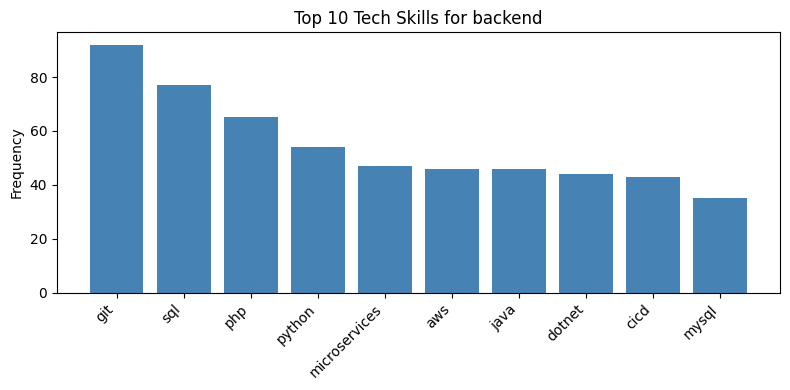

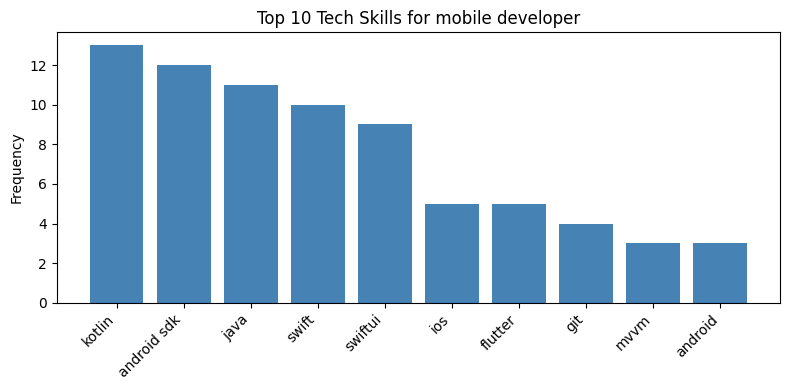

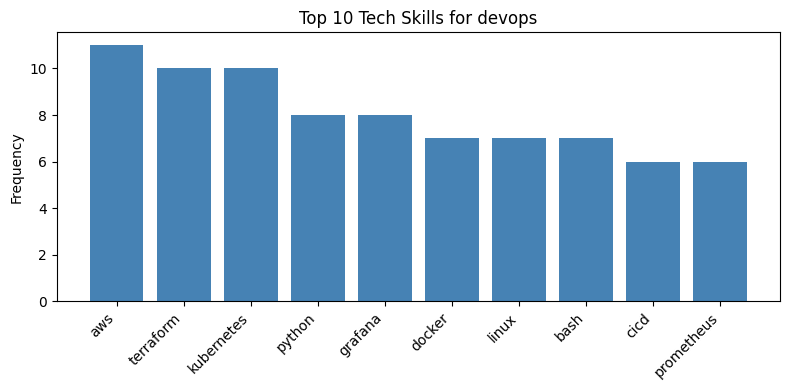

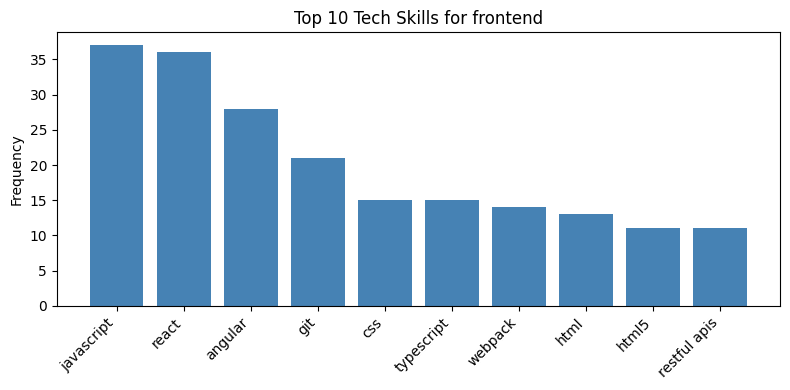

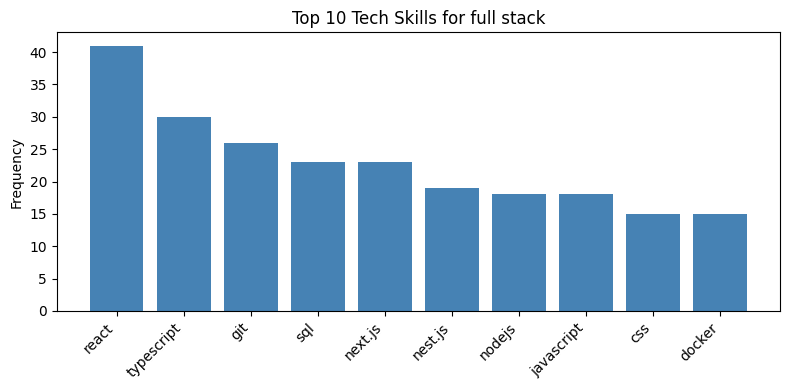

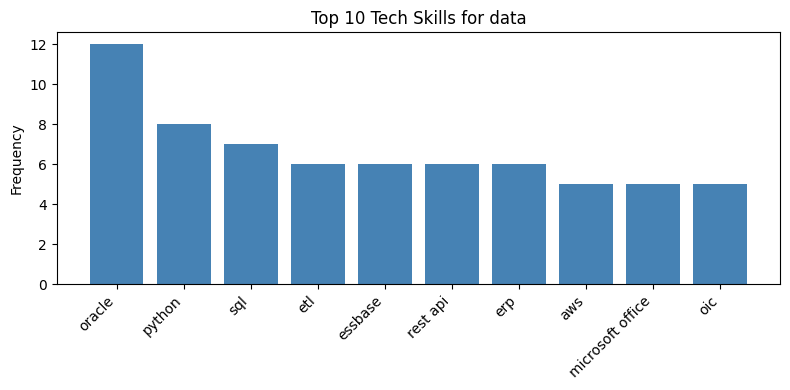

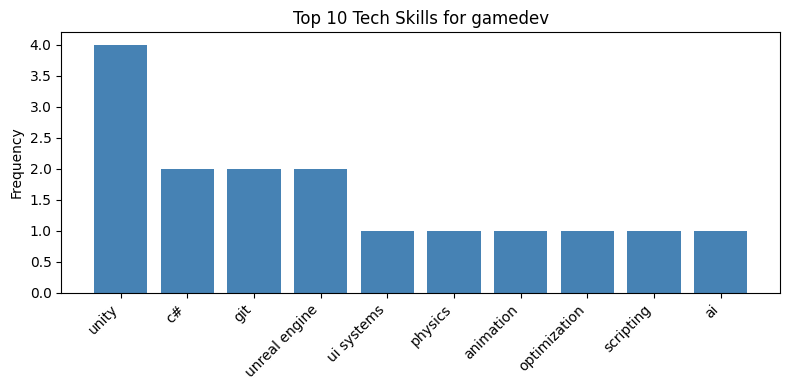

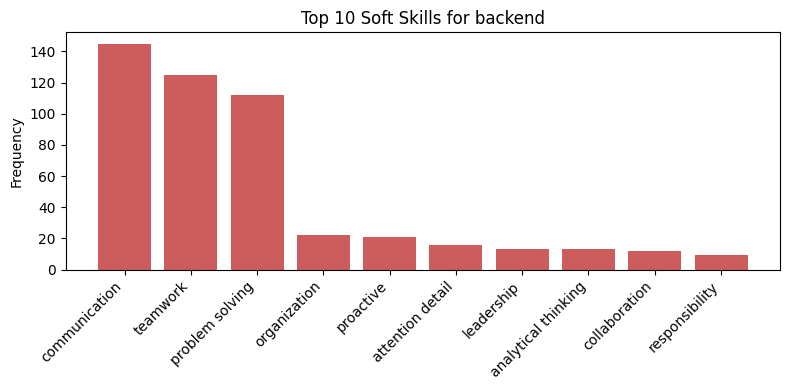

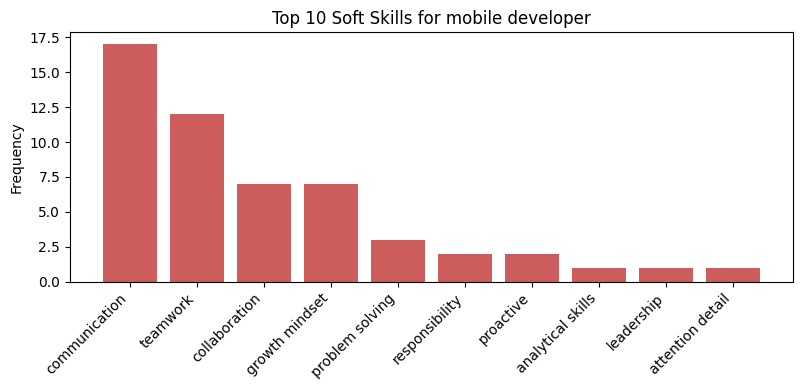

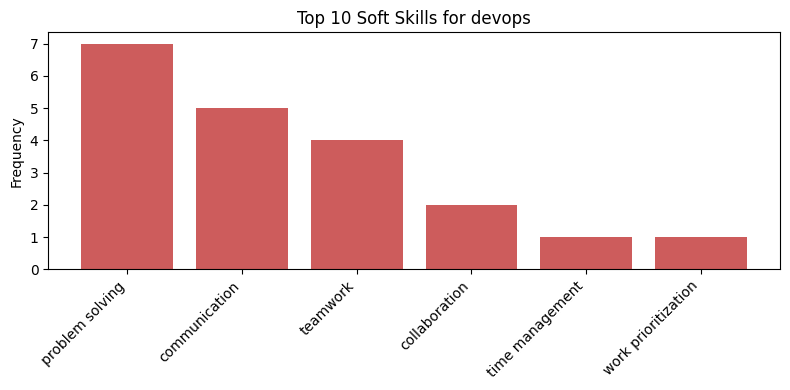

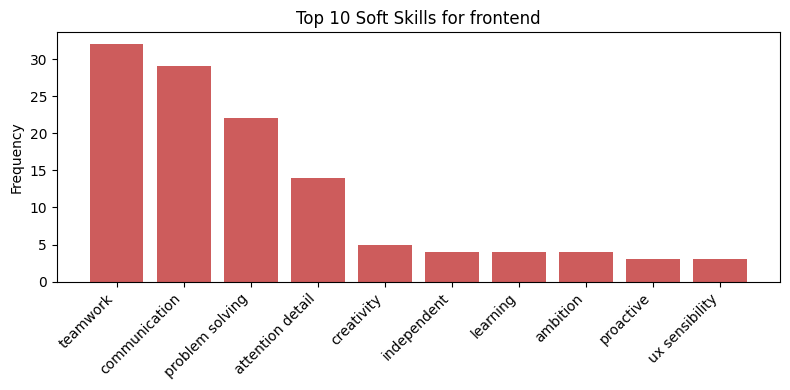

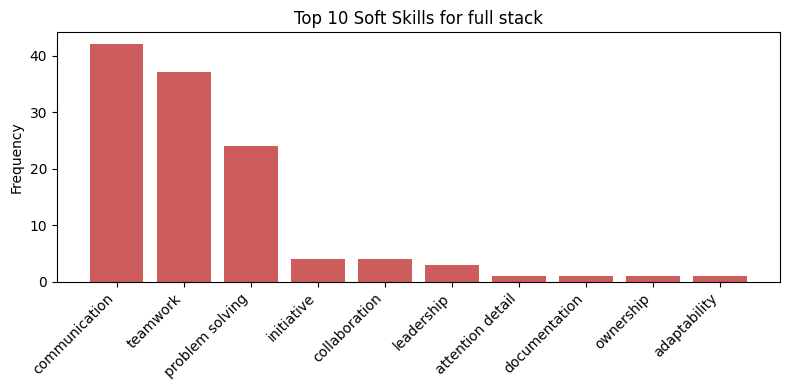

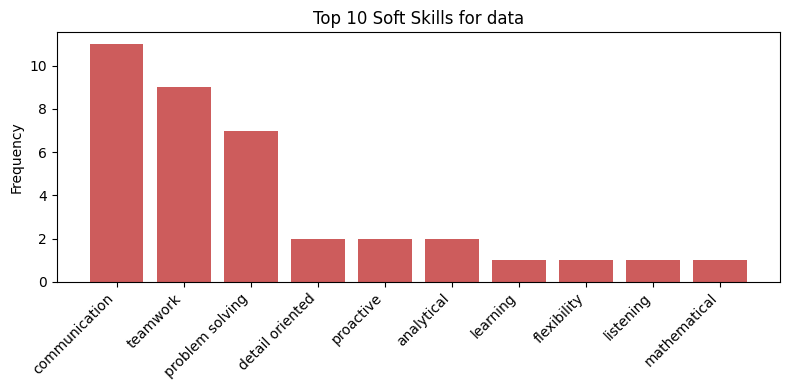

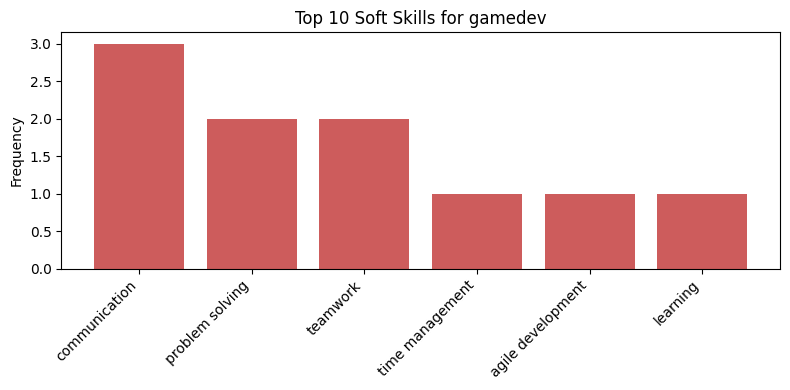

In [17]:
# Create DataFrame for tech skills counts
# Plot tech skills (top 10 per job)
for job in filtered_df['generic_title'].unique():
    tech_counts = tech_data[job].most_common(10)
    if tech_counts:
        skills, counts = zip(*tech_counts)
        plt.figure(figsize=(8, 4))
        plt.bar(skills, counts, color='steelblue')
        plt.title(f'Top 10 Tech Skills for {job}')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

# Plot soft skills (top 10 per job)
for job in filtered_df['generic_title'].unique():
    soft_counts = soft_data[job].most_common(10)
    if soft_counts:
        skills, counts = zip(*soft_counts)
        plt.figure(figsize=(8, 4))
        plt.bar(skills, counts, color='indianred')
        plt.title(f'Top 10 Soft Skills for {job}')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()


## Hard skills table

In [18]:
# Display
# print("\n=== Top 25 Tech Skills per Job ===")
display(tech_ranked_df)

,backend,mobile developer,devops,frontend,full stack,data,gamedev
Rank 1,git (92),kotlin (13),aws (11),javascript (37),react (41),oracle (12),unity (4)
Rank 2,sql (77),android sdk (12),terraform (10),react (36),typescript (30),python (8),c# (2)
Rank 3,php (65),java (11),kubernetes (10),angular (28),git (26),sql (7),git (2)
Rank 4,python (54),swift (10),python (8),git (21),sql (23),etl (6),unreal engine (2)
Rank 5,microservices (47),swiftui (9),grafana (8),css (15),next.js (23),essbase (6),ui systems (1)
Rank 6,aws (46),ios (5),docker (7),typescript (15),nest.js (19),rest api (6),physics (1)
Rank 7,java (46),flutter (5),linux (7),webpack (14),nodejs (18),erp (6),animation (1)
Rank 8,dotnet (44),git (4),bash (7),html (13),javascript (18),aws (5),optimization (1)
Rank 9,cicd (43),mvvm (3),cicd (6),html5 (11),css (15),microsoft office (5),scripting (1)
Rank 10,mysql (35),android (3),prometheus (6),restful apis (11),docker (15),oic (5),ai (1)


## Soft skills table

In [19]:
# print("\n=== Top 25 Soft Skills per Job ===")
display(soft_ranked_df)

,backend,mobile developer,devops,frontend,full stack,data,gamedev
Rank 1,communication (145),communication (17),problem solving (7),teamwork (32),communication (42),communication (11),communication (3)
Rank 2,teamwork (125),teamwork (12),communication (5),communication (29),teamwork (37),teamwork (9),problem solving (2)
Rank 3,problem solving (112),collaboration (7),teamwork (4),problem solving (22),problem solving (24),problem solving (7),teamwork (2)
Rank 4,organization (22),growth mindset (7),collaboration (2),attention detail (14),initiative (4),detail oriented (2),time management (1)
Rank 5,proactive (21),problem solving (3),time management (1),creativity (5),collaboration (4),proactive (2),agile development (1)
Rank 6,attention detail (16),responsibility (2),work prioritization (1),independent (4),leadership (3),analytical (2),learning (1)
Rank 7,leadership (13),proactive (2),,learning (4),attention detail (1),learning (1),
Rank 8,analytical thinking (13),analytical skills (1),,ambition (4),documentation (1),flexibility (1),
Rank 9,collaboration (12),leadership (1),,proactive (3),ownership (1),listening (1),
Rank 10,responsibility (9),attention detail (1),,ux sensibility (3),adaptability (1),mathematical (1),


## Job positions open

/tmp/ipykernel_161762/1874332190.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(job_date_counts))


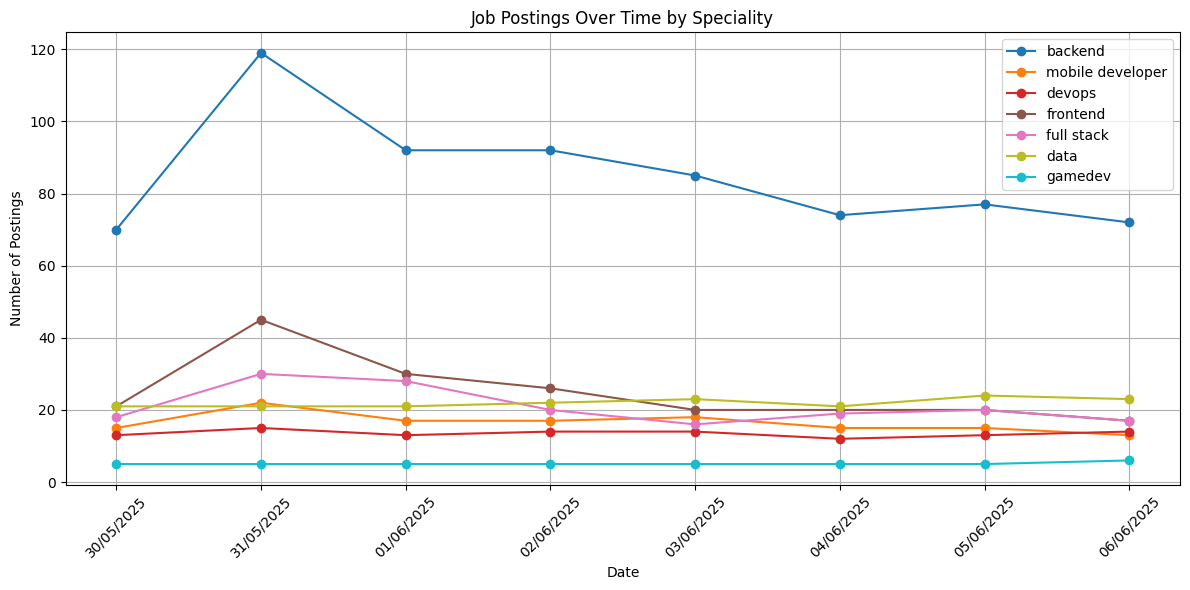

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
from utils import parse_date

# Prepare dictionary: {job_title: Counter({date: count})}
job_date_counts = defaultdict(Counter)

# Iterate through rows to populate job_date_counts
for _, row in filtered_df.iterrows():
    job = row['generic_title']
    occurrences = row['occurrences']
    if not occurrences:
        continue
    if isinstance(occurrences, str):
        occurrences = [occurrences]
    for date_str in occurrences:
        date = parse_date(date_str)
        if date:
            job_date_counts[job][date] += 1

# Plot
plt.figure(figsize=(12, 6))

# Choose distinct colors automatically
colors = plt.cm.get_cmap('tab10', len(job_date_counts))

for i, (job, date_counter) in enumerate(job_date_counts.items()):
    sorted_dates = sorted(date_counter.items())
    if not sorted_dates:
        continue
    dates, counts = zip(*sorted_dates)
    plt.plot(dates, counts, label=job, color=colors(i), marker='o')

# Formatting
plt.title("Job Postings Over Time by Speciality")
plt.xlabel("Date")
plt.ylabel("Number of Postings")
plt.grid(True)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Most common occurences of keywords

## Responsabilities

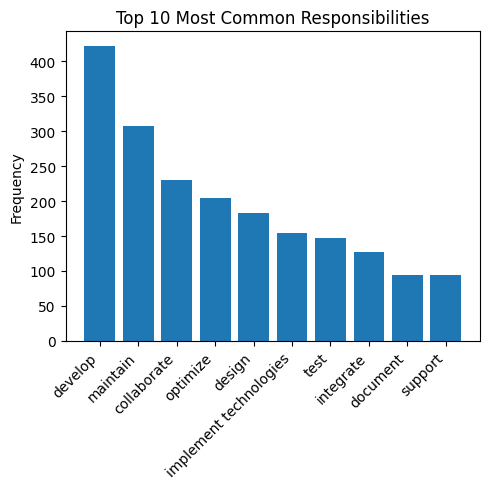

Full list of consolidated responsibilities term frequencies:

develop              422
maintain             307
collaborate          230
optimize             205
design               183
implement technologies 154
test                 147
integrate            127
document             94
support              94
review               65
debug                60
improve              59
manage               47
troubleshoot         47
build                46
analyze              45
deploy               44
monitor              36
mentor               34
generate             32
define               30
resolve              29
correct responses    29
deliver              24
write                24
lead                 23
participate          23
create test cases    23
ensure               22
contribute           20
configure            19
communicate          16
scale                16
code                 14
plan                 14
fix                  14
train                13
research        

In [21]:
tech_counts, tech_clusters = analyze_and_visualize_consolidated_terms(df, 'responsibilities', similarity_threshold=0.34, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

## Hard Skills

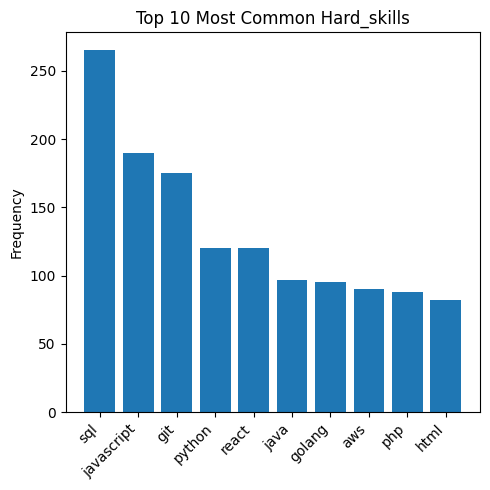

Full list of consolidated hard_skills term frequencies:

sql                  265
javascript           190
git                  175
python               120
react                120
java                 97
golang               95
aws                  90
php                  88
html                 82
web services         81
css                  79
docker               78
rest                 75
postgresql           73
cicd                 72
linux                71
dotnet               63
nestjs               51
kubernetes           48
c++                  47
nodejs               41
azure                40
android              40
spring boot          39
mongodb              38
laravel              37
ai                   37
restful api          37
vue                  36
tailwind css         36
redis                35
oracle               34
kafka                33
nagios               33
next.js              32
google cloud         30
oop                  28
cypress              27
sy

In [22]:
tech_counts, tech_clusters = analyze_and_visualize_consolidated_terms(df, 'hard_skills', similarity_threshold=0.34, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

## Soft Skills

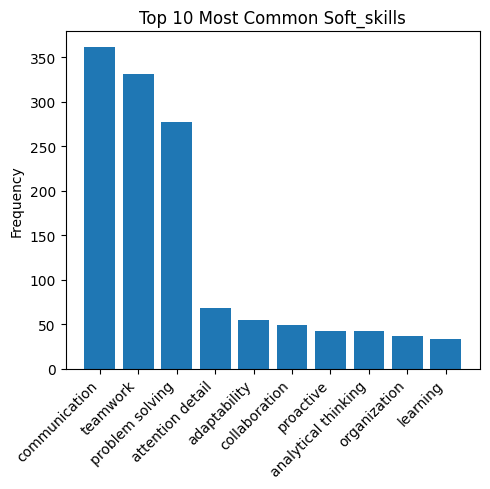

Full list of consolidated soft_skills term frequencies:

communication        361
teamwork             331
problem solving      277
attention detail     68
adaptability         55
collaboration        49
proactive            42
analytical thinking  42
organization         37
learning             33
leadership           31
motivated            31
responsibility       22
independence         16
detail oriented      11
interpersonal        11
fast learner         9
mentorship           9
time management      8
multitasking         7
creativity           7
growth mindset       7
initiative           6
documentation        6
ambition             5
flexibility          4
results-oriented     4
patience             4
results-focused      4
curiosity            4
negotiation          3
customer oriented    3
professionalism      2
agile development    2
autonomous           2
self-improvement     2
eager to grow        2
innovation           2
commitment           2
teaching             2
flex

In [23]:
soft_counts, soft_clusters = analyze_and_visualize_consolidated_terms(df, 'soft_skills', similarity_threshold=0.4, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

## Benefits

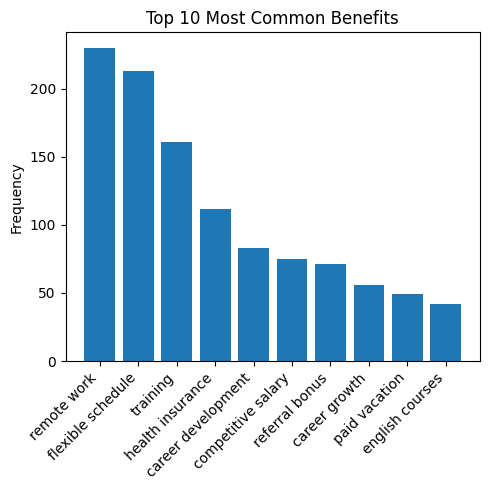

Full list of consolidated benefits term frequencies:

remote work          230
flexible schedule    213
training             161
health insurance     112
career development   83
competitive salary   75
referral bonus       71
career growth        56
paid vacation        49
english courses      42
corporate gifts      42
paid lunch           39
unlimited pto        39
paid holidays        39
team building        33
company perks        32
social package       31
growth opportunities 29
sports compensation  29
transport            28
maternity leave      28
hybrid work          25
professional growth  23
language classes     23
sick leave           22
medical coverage     21
comprehensive benefits 20
psychological support 20
performance bonus    20
fitness discounts    18
education bonuses    16
meal tickets         16
childcare budget     16
travel               14
portfolio enhancement 13
equipment            12
snacks               11
modern office        11
work-life balance    11
gy

In [24]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'benefits', similarity_threshold=0.3, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

## Languages

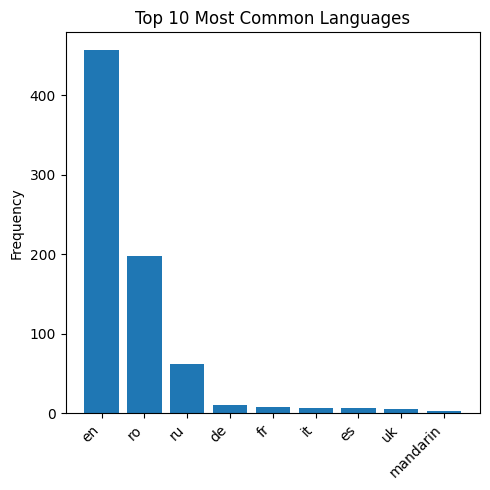

Full list of consolidated languages term frequencies:

en                   456
ro                   197
ru                   62
de                   10
fr                   8
it                   7
es                   6
uk                   5
mandarin             3

Consolidation details:


In [25]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'languages', similarity_threshold=0.3, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

## Education

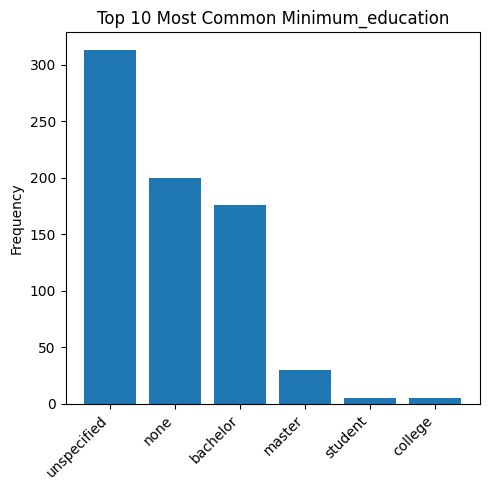

Full list of consolidated minimum_education term frequencies:

unspecified          313
none                 200
bachelor             176
master               30
student              5
college              5

Consolidation details:


In [26]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'minimum_education', similarity_threshold=0.3, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

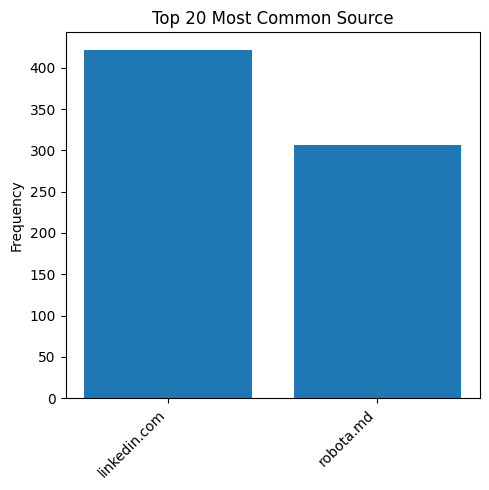

Full list of consolidated source term frequencies:

linkedin.com         422
robota.md            307

Consolidation details:


In [27]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'source', similarity_threshold=0.5, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

## Company Name

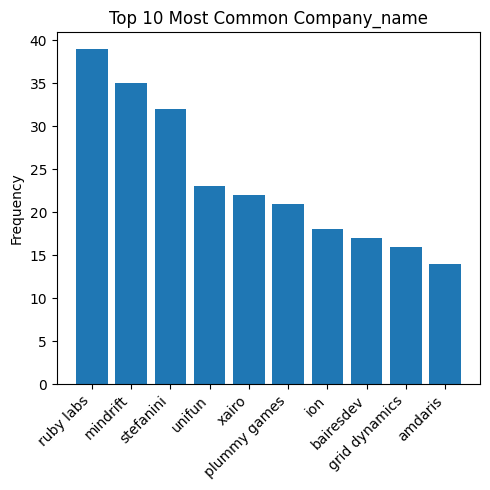

Full list of consolidated company_name term frequencies:

ruby labs            39
mindrift             35
stefanini            32
unifun               23
xairo                22
plummy games         21
ion                  18
bairesdev            17
grid dynamics        16
amdaris              14
orange systems       14
gr8 tech             13
endava               12
confidential co.     12
micro1               11
coherent solutions   10
gilat satellite networks 10
adtelligent          9
mixbook              9
orange moldova       8
nextapp              8
loleworks            8
insomniac design     8
kivork               7
backstageit          7
ebs integrator       7
s&t mold             7
hr consulting        7
braintrust           7
dyninno              6
maib                 6
7code                6
midnight works       5
meta-sistem s.r.l.   5
zazitex              5
moldindconbank       5
allied testing       5
identi               5
iaw                  5
canonical            5
b

In [28]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'company_name', similarity_threshold=0.5, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

## Company Size

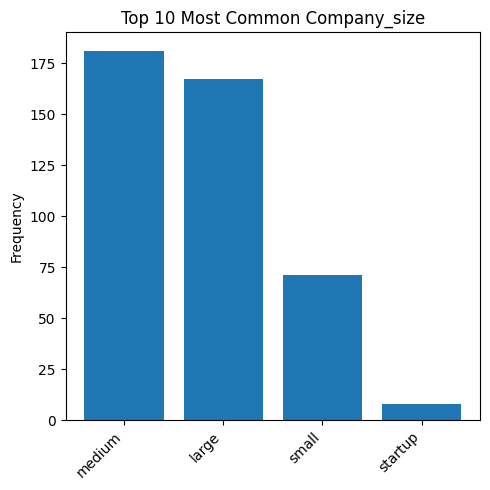

Full list of consolidated company_size term frequencies:

medium               181
large                167
small                71
startup              8

Consolidation details:


In [29]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'company_size', similarity_threshold=0.4, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

### Company Size Skills Required

In [30]:
import pandas as pd
from collections import Counter

# Filter rows where company_size is available
filtered_df = df[df['company_size'].notna()]

# Store counts per company size
skill_data = {}

for size in filtered_df['company_size'].unique():
    subset = filtered_df[filtered_df['company_size'] == size]
    
    skills = [skill for skills_list in subset['hard_skills'].dropna() 
              for skill in (skills_list if isinstance(skills_list, list) else [skills_list])]
    
    skill_counts = Counter(skills)
    skill_data[size] = skill_counts

# Build ranked table: rows = Rank 1..N, columns = company sizes
def build_ranked_df(skill_data, top_n=10):
    sizes = list(skill_data.keys())
    ranked_dict = {size: [] for size in sizes}
    
    for size in sizes:
        top_skills = skill_data[size].most_common(top_n)
        ranked_dict[size] = [f"{skill} ({count})" for skill, count in top_skills]
        
        # Pad with empty strings
        if len(ranked_dict[size]) < top_n:
            ranked_dict[size].extend([''] * (top_n - len(ranked_dict[size])))
    
    ranked_df = pd.DataFrame(ranked_dict, index=[f"Rank {i+1}" for i in range(top_n)])
    return ranked_df

# Generate and show the ranked DataFrame
hard_skills_ranked_df = build_ranked_df(skill_data, top_n=15)
hard_skills_ranked_df


,large,medium,startup,small
Rank 1,sql (55),sql (61),wordpress (4),javascript (30)
Rank 2,python (50),git (61),git (4),php (26)
Rank 3,git (43),react (41),python (3),react (20)
Rank 4,java (43),typescript (31),pyqt5 (3),mysql (19)
Rank 5,cicd (37),aws (30),pyqt6 (3),git (19)
Rank 6,dotnet (33),microservices (28),tkinter (3),laravel (17)
Rank 7,javascript (28),ai (28),pandas (3),python (15)
Rank 8,aws (24),c++ (25),openpyxl (3),aws (12)
Rank 9,docker (24),java (23),1c (3),sql (11)
Rank 10,rest (21),ios (23),com interop (3),typescript (10)


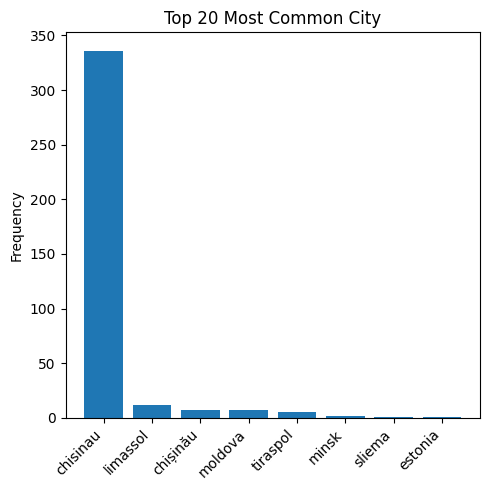

Full list of consolidated city term frequencies:

chisinau             336
limassol             12
chișinău             7
moldova              7
tiraspol             5
minsk                2
sliema               1
estonia              1

Consolidation details:


In [31]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'city', similarity_threshold=0.4, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

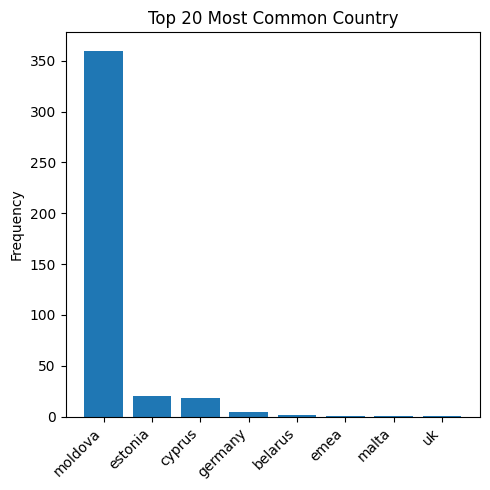

Full list of consolidated country term frequencies:

moldova              360
estonia              20
cyprus               18
germany              4
belarus              2
emea                 1
malta                1
uk                   1

Consolidation details:


In [32]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'country', similarity_threshold=0.3, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

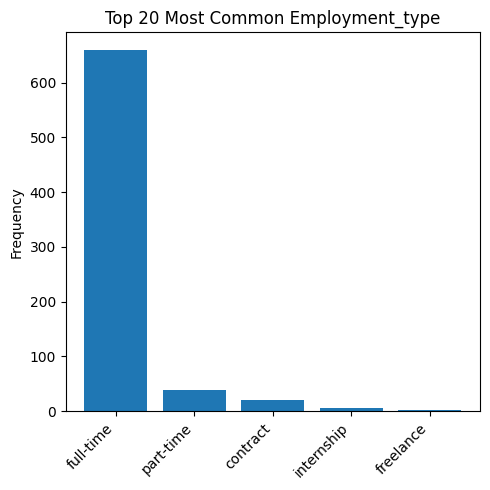

Full list of consolidated employment_type term frequencies:

full-time            659
part-time            38
contract             20
internship           6
freelance            3

Consolidation details:


In [33]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'employment_type', similarity_threshold=0.4, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

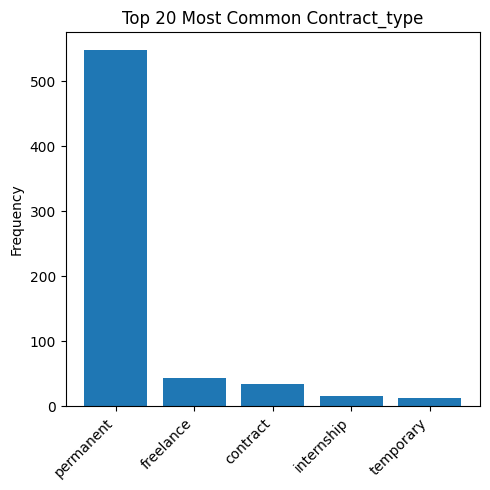

Full list of consolidated contract_type term frequencies:

permanent            548
freelance            43
contract             34
internship           16
temporary            13

Consolidation details:


In [34]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'contract_type', similarity_threshold=0.4, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

# Work Schedule

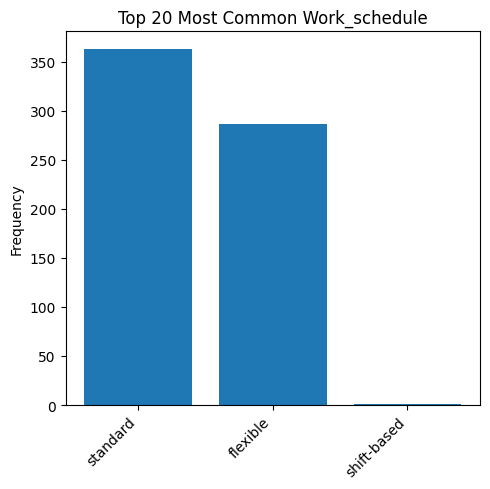

Full list of consolidated work_schedule term frequencies:

standard             363
flexible             287
shift-based          1

Consolidation details:


In [35]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'work_schedule', similarity_threshold=0.4, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

# Remote Work

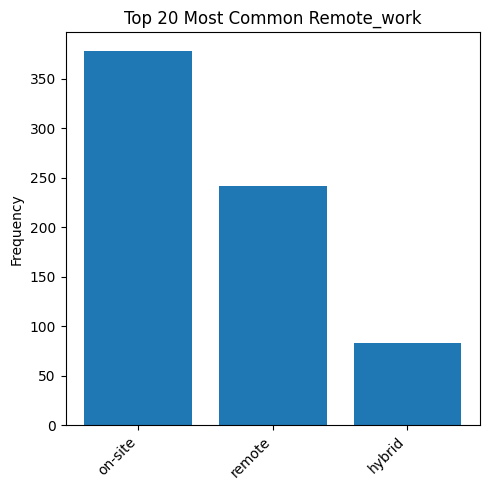

Full list of consolidated remote_work term frequencies:

on-site              378
remote               242
hybrid               83

Consolidation details:


In [36]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'remote_work', similarity_threshold=0.3, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

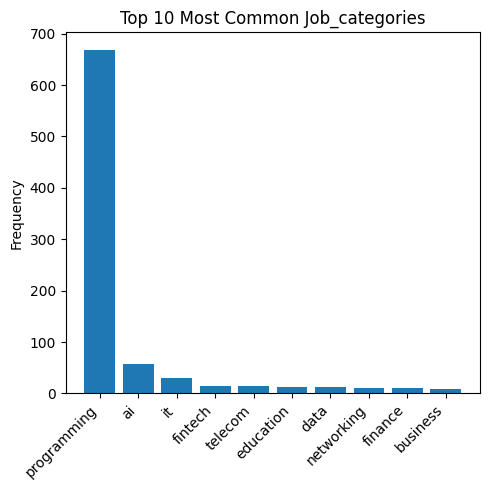

Full list of consolidated job_categories term frequencies:

programming          669
ai                   57
it                   30
fintech              15
telecom              15
education            13
data                 12
networking           11
finance              10
business             9
web development      9
testing              8
sales                8
it support           7
management           7
banking              6
system administration 5
technology           5
gamedev              4
cyber security       4
analysis             4
video editing        4
e-learning           4
qa                   3
cloud                3
engineering          3
data analytics       3
travel               2
human resources      2
hospitality          2
consulting           2
developer relations  2
devops               2
construction         1
accounting           1
supply chain         1
design               1
it services          1
regional planning    1
blockchain           1
market re

In [37]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'job_categories', similarity_threshold=0.3, n=2, top_n=10, 
                                     figsize=(5, 5), rotation=45, show_details=True)

# Salary Currency

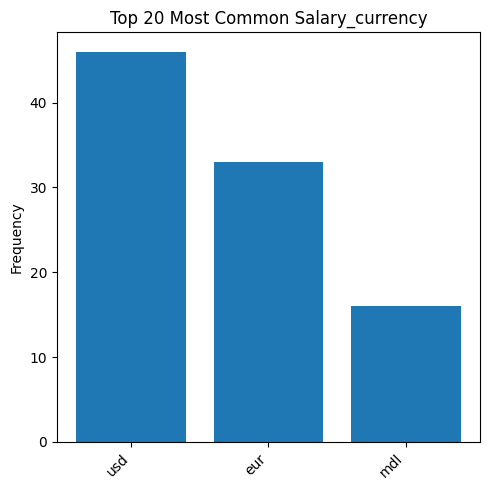

Full list of consolidated salary_currency term frequencies:

usd                  46
eur                  33
mdl                  16

Consolidation details:


In [38]:
benefits_counts, benefits_clusters = analyze_and_visualize_consolidated_terms(df, 'salary_currency', similarity_threshold=0.3, n=2, top_n=20, 
                                     figsize=(5, 5), rotation=45, show_details=True)

# Experience Distribution

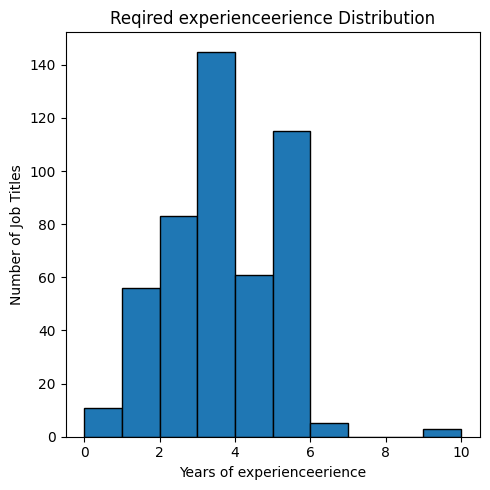

experienceerience Stats (After Dropping NaN):

count    479.000000
mean       3.206681
std        1.515981
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       10.000000
Name: experience, dtype: float64


In [39]:
df['experience'] = pd.to_numeric(df['experience'], errors='coerce')
df_clean = df.dropna(subset=['experience'])

# Plot experienceerience distribution
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(df_clean['experience'], bins=range(int(df_clean['experience'].min()), int(df_clean['experience'].max()) + 1), edgecolor='black')
ax.set_title('Reqired experienceerience Distribution')
ax.set_xlabel('Years of experienceerience')
ax.set_ylabel('Number of Job Titles')
plt.tight_layout()
plt.show()

# Print experienceerience stats for cleaned data
print("experienceerience Stats (After Dropping NaN):\n")
print(df_clean['experience'].describe())


# Salary distribution

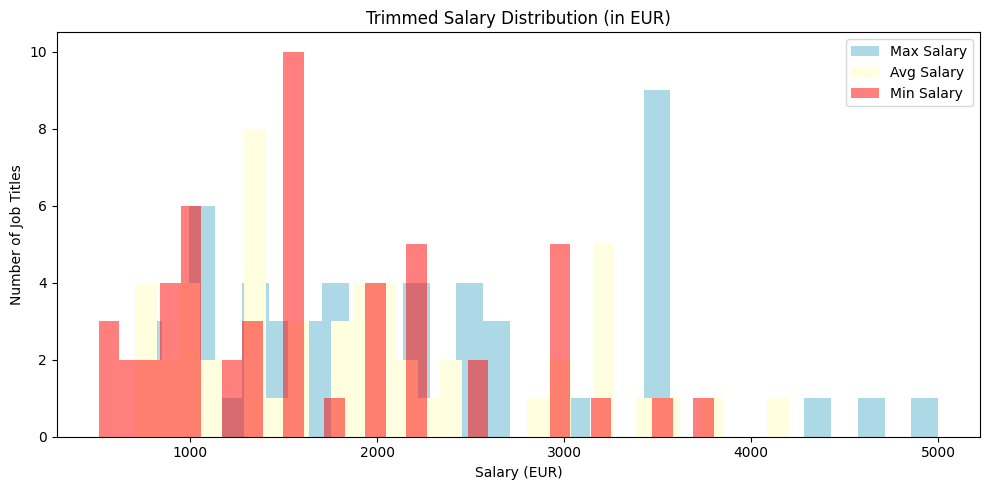

Salary Stats (on 52 salaries) (in EUR, After Conversion & Trimming):

       salary_min_eur  salary_avg_eur  salary_max_eur
count       52.000000       52.000000       52.000000
mean      1679.615385     1940.971154     2202.326923
std        835.398394      907.685153     1064.005118
min        510.000000      704.000000      704.000000
25%       1000.000000     1320.000000     1320.000000
50%       1542.000000     1785.000000     2010.000000
75%       2200.000000     2420.000000     2730.000000
max       3800.000000     4200.000000     5000.000000


In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `df` is already loaded

# Conversion rates to EUR
currency_rates = {
    'usd': 0.88,
    'mdl': 0.051,
    'eur': 1.0,
    'gbp': 1.17
}

# Function to convert salary to EUR
def convert_to_eur(row):
    currency = (row.get('salary_currency') or '').lower()
    rate = currency_rates.get(currency)
    
    if rate and pd.notnull(row.get('min_salary')):
        min_salary_eur = row['min_salary'] * rate
        max_salary = row.get('max_salary')
        max_salary_eur = max_salary * rate if pd.notnull(max_salary) else None
    else:
        min_salary_eur = max_salary_eur = None
    
    return pd.Series([min_salary_eur, max_salary_eur])

# Convert salaries to EUR
df[['salary_min_eur', 'salary_max_eur']] = df.apply(convert_to_eur, axis=1)
df_clean = df.dropna(subset=['salary_min_eur', 'salary_max_eur']).copy()
df_clean['salary_avg_eur'] = (df_clean['salary_min_eur'] + df_clean['salary_max_eur']) / 2

# Sort and trim top/bottom 3 in each salary column
def trim_outliers(df, column, n=3):
    return df.sort_values(by=column).iloc[n:-n]

df_trimmed = df_clean.copy()
for col in ['salary_min_eur', 'salary_avg_eur', 'salary_max_eur']:
    df_trimmed = trim_outliers(df_trimmed, col, 2)

# Plot salary distributions (trimmed)
plt.figure(figsize=(10, 5))
plt.hist(df_trimmed['salary_max_eur'], bins=30, alpha=1, label='Max Salary', color='lightblue')
plt.hist(df_trimmed['salary_avg_eur'], bins=30, alpha=1, label='Avg Salary', color='lightyellow')
plt.hist(df_trimmed['salary_min_eur'], bins=30, alpha=0.5, label='Min Salary', color='red')
plt.title('Trimmed Salary Distribution (in EUR)')
plt.xlabel('Salary (EUR)')
plt.ylabel('Number of Job Titles')
plt.legend()
plt.tight_layout()
plt.show()

# Print salary stats (trimmed)
print(f"Salary Stats (on {len(df_trimmed)} salaries) (in EUR, After Conversion & Trimming):\n")
print(df_trimmed[['salary_min_eur', 'salary_avg_eur', 'salary_max_eur']].describe())


## Salary per specialization

In [41]:
import pandas as pd

# Assuming `df` is already loaded with 'salary_max_eur' and 'title' columns

# Create a new column combining title and maximum salary to identify unique pairs
df['title_salary_pair'] = df['title'].astype(str) + '_' + df['salary_max_eur'].astype(str)

# Drop duplicate rows based on the 'title_salary_pair' column, keeping the first occurrence
df_unique_title_salary = df.drop_duplicates(subset=['title_salary_pair'], keep='first')

# Sort the unique pairs by 'salary_max_eur' in descending order
df_sorted_unique = df_unique_title_salary.sort_values(by='salary_max_eur', ascending=False)

# Display the job titles and their maximum salaries (for the top 20 unique pairs)
print("Unique Job Titles and Maximum Salary Pairs (Highest Salary First):\n")
print(df_sorted_unique[['title', 'salary_max_eur']][:11])


print("Unique Job Titles and Minimum Salary Pairs (Lowest Salary First):\n")
print(df_sorted_unique.dropna(subset=['salary_max_eur'])[['title', 'salary_max_eur']].tail(10))

# Optionally, you can drop the temporary 'title_salary_pair' column if you no longer need it
df = df.drop(columns=['title_salary_pair'])

Unique Job Titles and Maximum Salary Pairs (Highest Salary First):

                        title  salary_max_eur
591       wordpress developer         90000.0
205         backend developer          7000.0
150          python developer          5000.0
619          golang developer          4600.0
170       fullstack developer          4400.0
69   chief technology officer          3520.0
92           nodejs developer          3520.0
178             ios developer          3500.0
185         android developer          3500.0
96              php developer          3500.0
86          flutter developer          3000.0
Unique Job Titles and Minimum Salary Pairs (Lowest Salary First):

                           title  salary_max_eur
237  oracle databases internship         1000.00
82              qa manual tester          765.00
71   linux network administrator          704.00
91                 php developer          704.00
52         dotnet core developer          704.00
81            front

In [42]:
df_clean_salaries = df_trimmed.copy()
filtered_df = df_clean_salaries[df_clean_salaries['generic_title'].notna()].copy()

# Analysis by job specialty
job_specialties = filtered_df['generic_title'].value_counts()
print("Job Specialties Distribution:")
for specialty, count in job_specialties.items():
    print(f"{specialty}: {count} positions")
print("\n" + "="*80 + "\n")

# Create salary analysis for each specialty with sufficient data (at least 3 positions)
min_positions = 3
specialties_with_data = job_specialties[job_specialties >= min_positions].index

# Calculate stats for each specialty
specialty_stats = {}
for specialty in specialties_with_data:
    specialty_data = filtered_df[filtered_df['generic_title'] == specialty]
    specialty_stats[specialty] = specialty_data[['salary_min_eur', 'salary_avg_eur', 'salary_max_eur']].describe()

# Print detailed stats for each specialty
for specialty in specialties_with_data:
    specialty_data = filtered_df[filtered_df['generic_title'] == specialty]
    count = len(specialty_data)
    
    print(f"{specialty.upper()} Salary Stats (on {count} salaries)(in EUR, After Conversion):\n")
    print(specialty_stats[specialty])
    print("\n" + "-"*60 + "\n")

# Summary table of all specialties
print("SALARY SUMMARY BY JOB SPECIALTY (in EUR):")
print("="*80)

summary_data = []
for specialty in df_clean_salaries['generic_title'].unique():
    specialty_data = df_clean_salaries[df_clean_salaries['generic_title'] == specialty]
    if len(specialty_data) > 0:
        summary_data.append({
            'Specialty': specialty,
            'Count': len(specialty_data),
            'Min Salary (Avg)': round(specialty_data['salary_min_eur'].mean(), 0),
            'Avg Salary (Avg)': round(specialty_data['salary_avg_eur'].mean(), 0),
            'Max Salary (Avg)': round(specialty_data['salary_max_eur'].mean(), 0),
            'Median Avg Salary': round(specialty_data['salary_avg_eur'].median(), 0)
        })

summary_df = pd.DataFrame(summary_data).sort_values('Avg Salary (Avg)', ascending=False)
print(summary_df.to_string(index=False))

Job Specialties Distribution:
backend: 23 positions
full stack: 3 positions
mobile developer: 3 positions
frontend: 2 positions
gamedev: 2 positions
data: 1 positions
devops: 1 positions


BACKEND Salary Stats (on 23 salaries)(in EUR, After Conversion):

       salary_min_eur  salary_avg_eur  salary_max_eur
count       23.000000       23.000000       23.000000
mean      1974.608696     2268.347826     2562.086957
std        830.696845      929.158728     1130.830464
min        704.000000      704.000000      704.000000
25%       1500.000000     1584.000000     1584.000000
50%       1600.000000     2100.000000     2500.000000
75%       2600.000000     3250.000000     3500.000000
max       3800.000000     4200.000000     5000.000000

------------------------------------------------------------

FULL STACK Salary Stats (on 3 salaries)(in EUR, After Conversion):

       salary_min_eur  salary_avg_eur  salary_max_eur
count         3.00000        3.000000        3.000000
mean       2376.0000

# Correlations
## Experience and salary

Correlation between Experience and Minimum Salary (EUR):
                experience  salary_min_eur
experience        1.000000        0.436523
salary_min_eur    0.436523        1.000000

Correlation between Experience and Maximum Salary (EUR):
                experience  salary_max_eur
experience        1.000000        0.438151
salary_max_eur    0.438151        1.000000


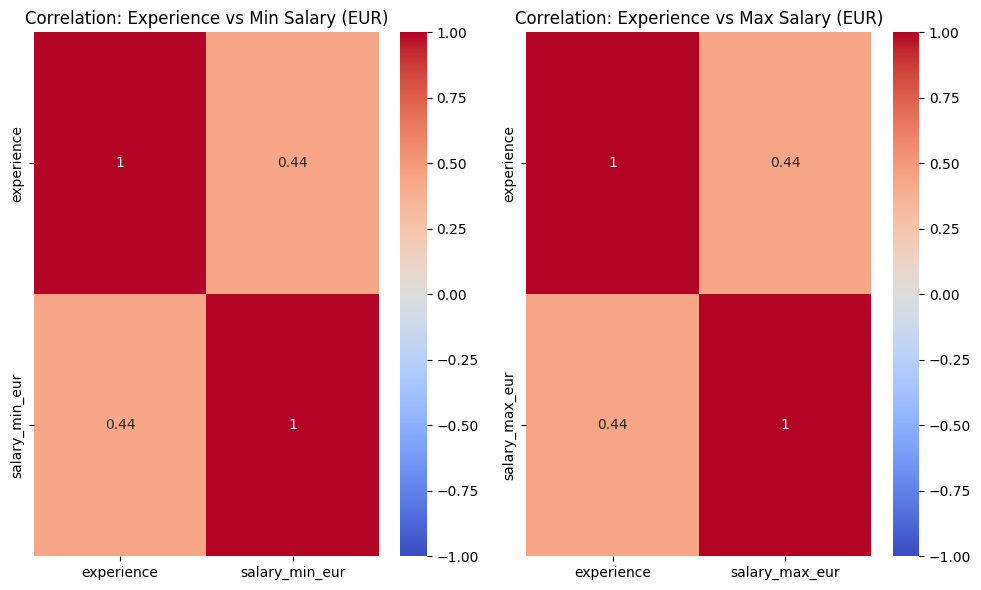

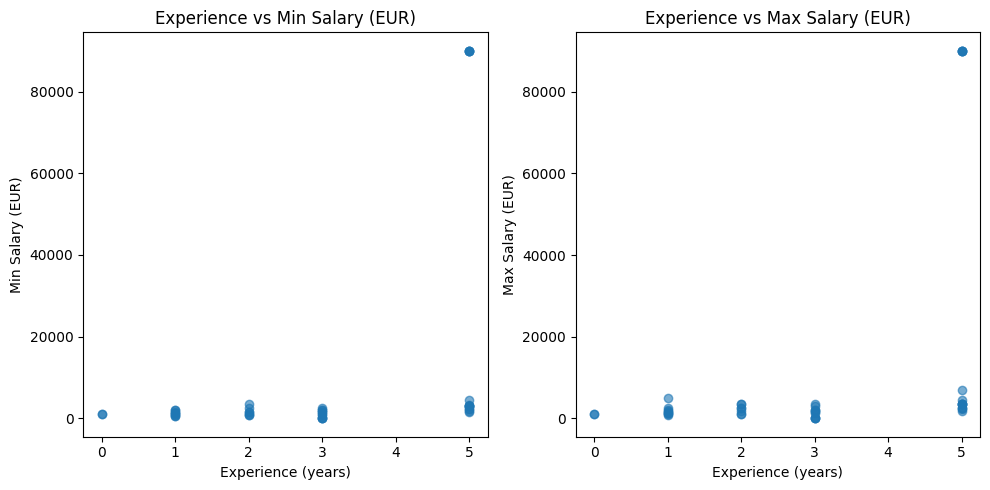

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where experience or salary (min or max) is missing
df_clean_corr = df.dropna(subset=['experience', 'salary_min_eur', 'salary_max_eur'])

# Compute correlation between experience and salaries
correlation_min = df_clean_corr[['experience', 'salary_min_eur']].corr()
correlation_max = df_clean_corr[['experience', 'salary_max_eur']].corr()

# Display correlation matrices
print("Correlation between Experience and Minimum Salary (EUR):")
print(correlation_min)
print("\nCorrelation between Experience and Maximum Salary (EUR):")
print(correlation_max)

# Plot heatmaps of the correlation matrices
plt.figure(figsize=(10, 6))

# Heatmap: Experience vs Min Salary
plt.subplot(1, 2, 1)
sns.heatmap(correlation_min, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation: Experience vs Min Salary (EUR)")

# Heatmap: Experience vs Max Salary
plt.subplot(1, 2, 2)
sns.heatmap(correlation_max, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation: Experience vs Max Salary (EUR)")

plt.tight_layout()
plt.show()

# Scatter plots for visual inspection
plt.figure(figsize=(10, 5))

# Scatter plot: Experience vs Min Salary
plt.subplot(1, 2, 1)
plt.scatter(df_clean_corr['experience'], df_clean_corr['salary_min_eur'], alpha=0.6)
plt.title("Experience vs Min Salary (EUR)")
plt.xlabel('Experience (years)')
plt.ylabel('Min Salary (EUR)')

# Scatter plot: Experience vs Max Salary
plt.subplot(1, 2, 2)
plt.scatter(df_clean_corr['experience'], df_clean_corr['salary_max_eur'], alpha=0.6)
plt.title("Experience vs Max Salary (EUR)")
plt.xlabel('Experience (years)')
plt.ylabel('Max Salary (EUR)')

plt.tight_layout()
plt.show()

## Salary and number of skills

Correlation Matrix (Average Salary vs Number of Skills):

                 salary_avg_eur  num_hard_skills  num_soft_skills
salary_avg_eur         1.000000         0.290608        -0.028024
num_hard_skills        0.290608         1.000000         0.592216
num_soft_skills       -0.028024         0.592216         1.000000


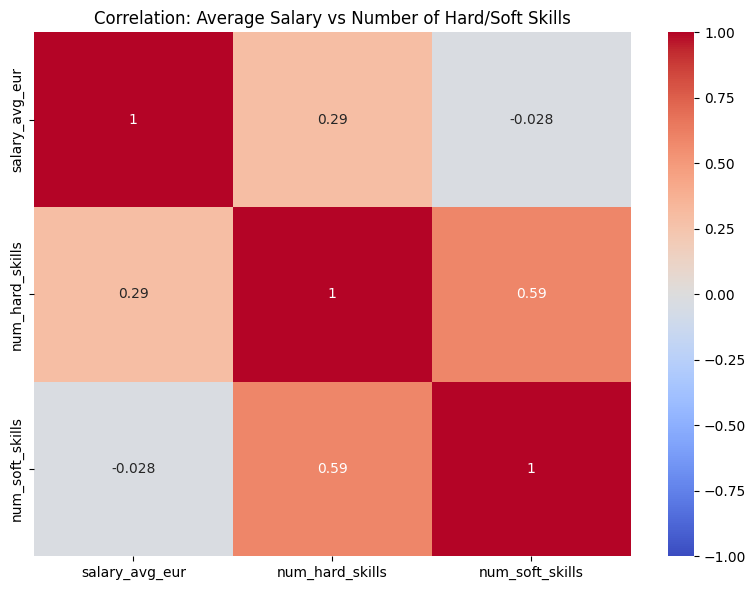

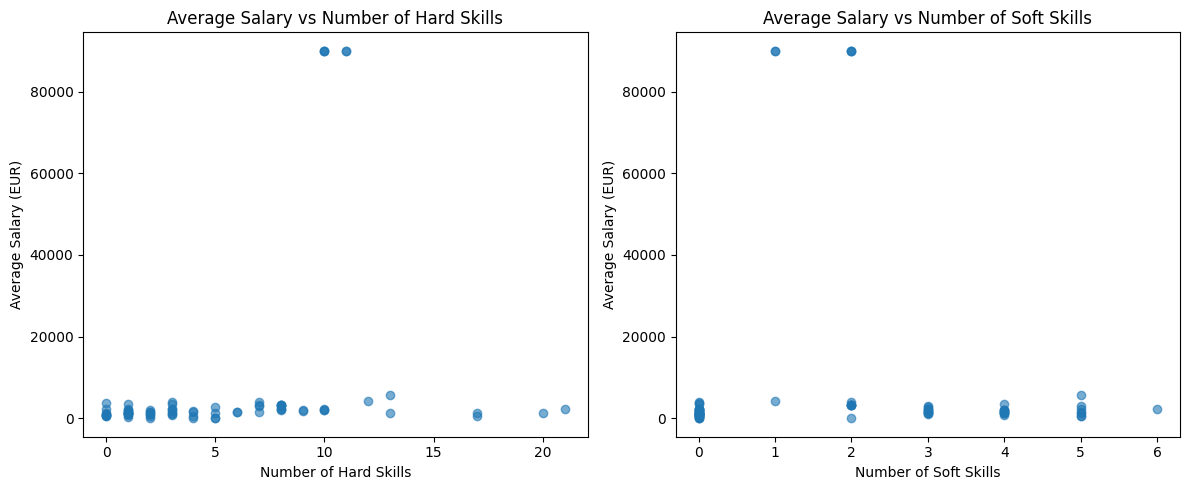

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` is already loaded and has `salary_min_eur` and `salary_max_eur` from your previous code

# 1. Calculate average salary (mean of min and max salaries)
df['salary_avg_eur'] = df[['salary_min_eur', 'salary_max_eur']].mean(axis=1)

# 2. Count the number of hard and soft skills
df['num_hard_skills'] = df['hard_skills'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['num_soft_skills'] = df['soft_skills'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# 3. Filter out rows where salary_avg_eur is NaN
df_clean_skills = df.dropna(subset=['salary_avg_eur'])

# 4. Calculate correlations between average salary and number of skills
correlation_skills = df_clean_skills[['salary_avg_eur', 'num_hard_skills', 'num_soft_skills']].corr()

# Print the correlation matrix
print("Correlation Matrix (Average Salary vs Number of Skills):\n")
print(correlation_skills)

# 5. Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_skills, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation: Average Salary vs Number of Hard/Soft Skills')
plt.tight_layout()
plt.show()

# 6. Plot scatter plots for better visual understanding
plt.figure(figsize=(12, 5))

# Scatter plot for Average Salary vs Number of Hard Skills
plt.subplot(1, 2, 1)
plt.scatter(df_clean_skills['num_hard_skills'], df_clean_skills['salary_avg_eur'], alpha=0.6)
plt.title('Average Salary vs Number of Hard Skills')
plt.xlabel('Number of Hard Skills')
plt.ylabel('Average Salary (EUR)')

# Scatter plot for Average Salary vs Number of Soft Skills
plt.subplot(1, 2, 2)
plt.scatter(df_clean_skills['num_soft_skills'], df_clean_skills['salary_avg_eur'], alpha=0.6)
plt.title('Average Salary vs Number of Soft Skills')
plt.xlabel('Number of Soft Skills')
plt.ylabel('Average Salary (EUR)')

plt.tight_layout()
plt.show()


## Expected experience and number of skills

Correlation Matrix (Experience vs Number of Skills):

                 experience  num_hard_skills  num_soft_skills
experience         1.000000         0.247138         0.236677
num_hard_skills    0.247138         1.000000         0.549423
num_soft_skills    0.236677         0.549423         1.000000


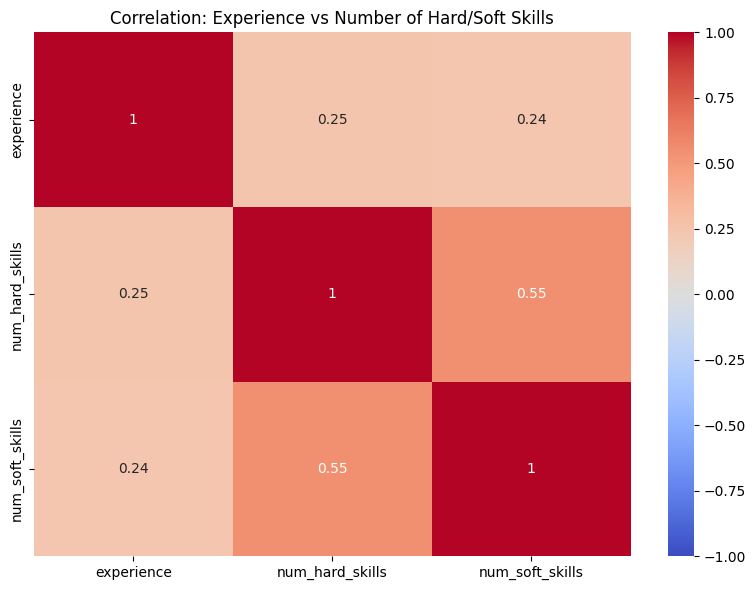

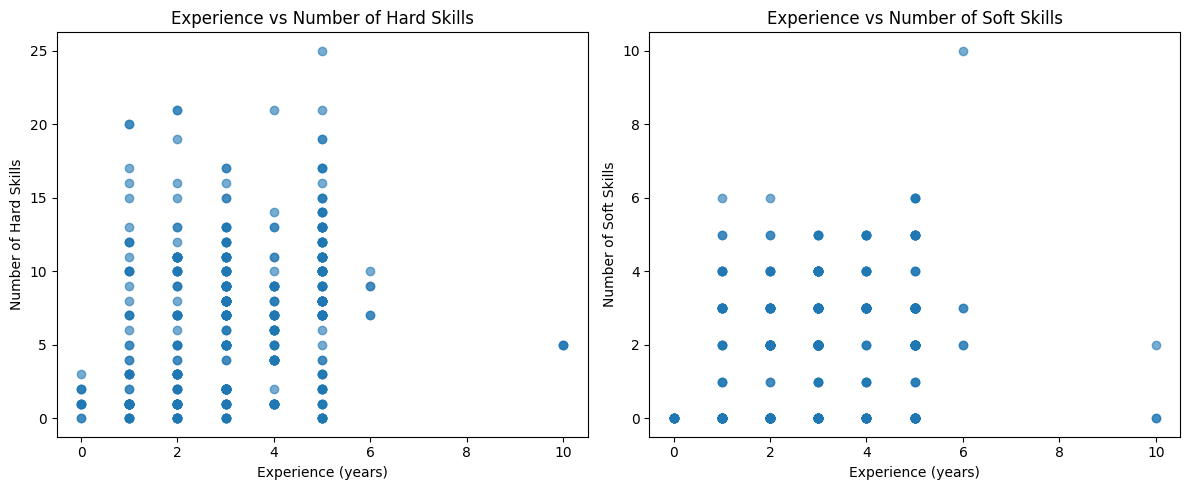

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` is already loaded

# Clean rows with NaN in 'experience', 'hard_skills', or 'soft_skills' and create a copy
df_clean_skills_exp = df.dropna(subset=['experience', 'hard_skills', 'soft_skills']).copy()

# Count the number of hard and soft skills
df_clean_skills_exp['num_hard_skills'] = df_clean_skills_exp['hard_skills'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_clean_skills_exp['num_soft_skills'] = df_clean_skills_exp['soft_skills'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Calculate correlations between experience and number of skills
correlation_exp_skills = df_clean_skills_exp[['experience', 'num_hard_skills', 'num_soft_skills']].corr()

# Print the correlation matrix
print("Correlation Matrix (Experience vs Number of Skills):\n")
print(correlation_exp_skills)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_exp_skills, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation: Experience vs Number of Hard/Soft Skills')
plt.tight_layout()
plt.show()

# Plot scatter plots for better visual understanding
plt.figure(figsize=(12, 5))

# Scatter plot for Experience vs Number of Hard Skills
plt.subplot(1, 2, 1)
plt.scatter(df_clean_skills_exp['experience'], df_clean_skills_exp['num_hard_skills'], alpha=0.6)
plt.title('Experience vs Number of Hard Skills')
plt.xlabel('Experience (years)')
plt.ylabel('Number of Hard Skills')

# Scatter plot for Experience vs Number of Soft Skills
plt.subplot(1, 2, 2)
plt.scatter(df_clean_skills_exp['experience'], df_clean_skills_exp['num_soft_skills'], alpha=0.6)
plt.title('Experience vs Number of Soft Skills')
plt.xlabel('Experience (years)')
plt.ylabel('Number of Soft Skills')

plt.tight_layout()
plt.show()


# Skill coocurences

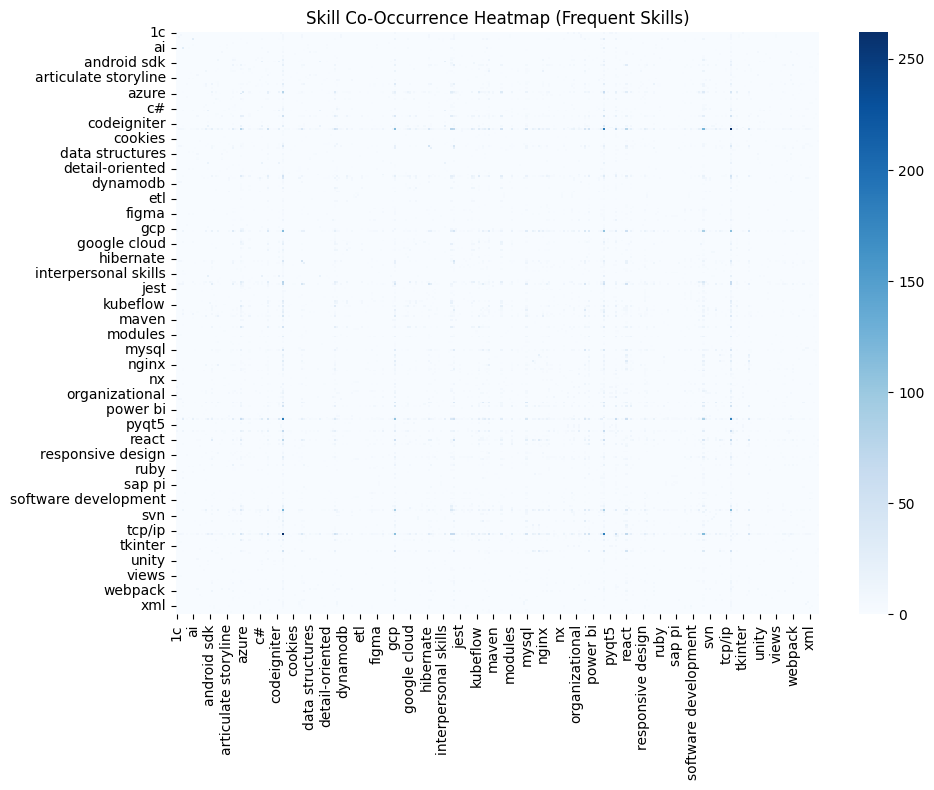

Top Skill Co-Occurrences:
communication & teamwork: 262 jobs
communication & problem solving: 186 jobs
problem solving & teamwork: 181 jobs
communication & sql: 123 jobs
sql & teamwork: 115 jobs
communication & git: 114 jobs
git & teamwork: 110 jobs
git & problem solving: 105 jobs
git & sql: 90 jobs
problem solving & sql: 88 jobs
aws & communication: 79 jobs
communication & java: 78 jobs
communication & react: 76 jobs
communication & javascript: 71 jobs
react & teamwork: 70 jobs
communication & python: 69 jobs
java & teamwork: 66 jobs
javascript & teamwork: 65 jobs
problem solving & python: 64 jobs
aws & problem solving: 63 jobs
python & teamwork: 61 jobs
problem solving & react: 57 jobs
cicd & communication: 56 jobs
git & react: 55 jobs
javascript & problem solving: 54 jobs
docker & teamwork: 52 jobs
cicd & teamwork: 52 jobs
communication & typescript: 52 jobs
postgresql & teamwork: 52 jobs
communication & microservices: 51 jobs
communication & docker: 51 jobs
javascript & react: 51 j

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Assuming df is already loaded
# Flatten all skills (hard + soft) into a single list per job
df['all_skills'] = df['hard_skills'] + df['soft_skills']

# Step 1: Collect unique skills incrementally and count frequencies
skill_counts = {}
for skills in df['all_skills']:
    for skill in skills:
        skill_counts[skill] = skill_counts.get(skill, 0) + 1

# Step 2: Filter skills appearing in at least 3 jobs
min_appearances = 3
frequent_skills = [skill for skill, count in skill_counts.items() if count >= min_appearances]
frequent_skills.sort()  # Sort for consistent ordering
skill_to_idx = {skill: idx for idx, skill in enumerate(frequent_skills)}

# Step 3: Create co-occurrence matrix using numpy
n_skills = len(frequent_skills)
co_occurrence_np = np.zeros((n_skills, n_skills), dtype=int)
for skills in df['all_skills']:
    # Only consider frequent skills
    job_skills = [skill for skill in skills if skill in skill_to_idx]
    skill_indices = [skill_to_idx[skill] for skill in job_skills]
    for i, j in combinations(skill_indices, 2):
        co_occurrence_np[i, j] += 1
        co_occurrence_np[j, i] += 1

# Convert to DataFrame for plotting
co_occurrence = pd.DataFrame(co_occurrence_np, index=frequent_skills, columns=frequent_skills)

# Step 4: Visualize as a heatmap
plt.figure(figsize=(10, 8))
annot = len(frequent_skills) <= 15
sns.heatmap(co_occurrence, cmap='Blues', annot=annot, fmt='d')
plt.title('Skill Co-Occurrence Heatmap (Frequent Skills)')
plt.tight_layout()
plt.show()

# Step 5: Alternative visualization - Bar chart of top co-occurrences
co_occurrence_stack = co_occurrence.where(np.triu(np.ones(co_occurrence.shape), k=1).astype(bool)).stack()
top_co_occurrences = co_occurrence_stack[co_occurrence_stack > 0].sort_values(ascending=False).head(50)

# Print top co-occurrences
print("Top Skill Co-Occurrences:")
for (skill1, skill2), count in top_co_occurrences.items():
    print(f"{skill1} & {skill2}: {int(count)} jobs")